# Import modules

In [1]:
import csv
import os
import pickle
import pytz
import torch
import timeit
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from copy import deepcopy
from datetime import datetime
from einops import rearrange
from itertools import chain
from time import time
from torch import nn, optim
from torchmetrics.classification import MulticlassAccuracy, MulticlassF1Score, MulticlassConfusionMatrix
from torch.optim import lr_scheduler
from tqdm.notebook import tqdm
from torch.utils.data import TensorDataset, DataLoader
from polyglot.mapping import Embedding, CaseExpander, DigitExpander

# Hyperparameters

In [2]:
class Hyperparams:
     def __init__(
        self,
        context_size=1,
        fold=1,
        max_seq_len=82,
        input_size=64,
        batch_size=32,
        num_hidden_layer=1,
        hidden_size=128,
        dropout=0,
        bias=True,
        output_size=24,
        shuffle=True,
        lr=0.005,
        batch_first=False,
        bidirectional=True,
        init_wb_with_kaiming_normal=True,
        n_epoch=50,
        patience=50,
        device="cuda" if torch.cuda.is_available() else "cpu"
    ):
        self.context_size = context_size
        self.fold = fold
        self.input_size = input_size
        self.max_seq_len = max_seq_len
        self.batch_size = batch_size
        self.num_hidden_layer = num_hidden_layer
        self.hidden_size = hidden_size
        self.dropout = dropout
        self.bias = bias
        self.output_size = output_size
        self.shuffle = shuffle
        self.lr = lr
        self.batch_first = batch_first
        self.bidirectional = bidirectional
        self.init_wb_with_kaiming_normal = init_wb_with_kaiming_normal
        self.n_epoch = n_epoch
        self.patience = patience
        self.device = device

hyperparams = Hyperparams()

# Dataset

In [3]:
id_pos_tag = pd.read_csv("../../../datasets/raw/Indonesian_Manually_Tagged_Corpus.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False) 
train = pd.read_csv(f"../../../datasets/raw/cv/train/train.0{hyperparams.fold}.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False)
val = pd.read_csv(f"../../../datasets/raw/cv/val/val.0{hyperparams.fold}.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False)
test = pd.read_csv(f"../../../datasets/raw/cv/test/test.0{hyperparams.fold}.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False)

# Pre-trained Word Embedding

In [4]:
embeddings = Embedding.load("../../../word_embeddings/polyglot/idn_embeddings.tar.bz2")
embeddings.apply_expansion(DigitExpander)
embeddings.apply_expansion(CaseExpander)

oov_embeddings = pickle.load(open(f"../../../logs/comick/{hyperparams.context_size}_contexts/10-11-2022_10-29-38/oov_embedding_dict.pkl", "rb"))

# Data Preprocessing

## Add OOV Flag

In [5]:
def add_oov_flag(tokens, embeddings):
    oov_flags = []
    
    for token in tqdm(tokens):
        try:
            if token not in embeddings:
                oov_flags.append(True)
            else:
                oov_flags.append(False)
        except:
            oov_flags.append(False)
        
    return pd.DataFrame(oov_flags, columns=["is_oov"])

id_pos_tag_oov_flags = add_oov_flag(id_pos_tag["token"].values, embeddings)
train_oov_flags = add_oov_flag(train["token"].values, embeddings)
val_oov_flags = add_oov_flag(val["token"].values, embeddings)
test_oov_flags = add_oov_flag(test["token"].values, embeddings)

  0%|          | 0/266652 [00:00<?, ?it/s]

  0%|          | 0/191567 [00:00<?, ?it/s]

  0%|          | 0/21461 [00:00<?, ?it/s]

  0%|          | 0/53624 [00:00<?, ?it/s]

## Concate OOV Flag

In [6]:
id_pos_tag_df = pd.concat([id_pos_tag, id_pos_tag_oov_flags], axis=1)
train_df = pd.concat([train, train_oov_flags], axis=1)
val_df = pd.concat([val, val_oov_flags], axis=1)
test_df = pd.concat([test, test_oov_flags], axis=1)

## Lowercase OOV Token

In [7]:
id_pos_tag_df['token'] = np.where(id_pos_tag_df['is_oov'] == True, id_pos_tag_df['token'].str.lower(), id_pos_tag_df['token'])
train_df['token'] = np.where(train_df['is_oov'] == True, train_df['token'].str.lower(), train_df['token'])
val_df['token'] = np.where(val_df['is_oov'] == True, val_df['token'].str.lower(), val_df['token'])
test_df['token'] = np.where(test_df['is_oov'] == True, test_df['token'].str.lower(), test_df['token'])

## Embedding Dict, Index to Token and Token to Index

In [8]:
tokens = list(id_pos_tag_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None))

def embedding_dict(tokens, embeddings, oov_embeddings):
    embedding = {}
    
    for token in tokens:
        if token[0] is not np.nan:
            if token[2] == False or token[0] in embeddings:
                embedding[token[0]] = embeddings[token[0]]
            else:
                embedding[token[0]] = oov_embeddings[token[0].lower()]

    return embedding

embedding_dict = embedding_dict(tokens, embeddings, oov_embeddings)
embedding_dict["<PAD>"] = embeddings["<PAD>"]
word_embeddings = nn.Embedding.from_pretrained(torch.FloatTensor(np.array(list(embedding_dict.values()))), padding_idx=list(embedding_dict.keys()).index("<PAD>"), freeze=True)

idx_to_token = {idx: token for idx, token in enumerate(list(embedding_dict.keys()))}
token_to_idx = {token: idx for idx, token in enumerate(list(embedding_dict.keys()))}

## Token to Sentence

In [9]:
def make_sentence(tokens, max_length_sentence=hyperparams.max_seq_len):
    sentence = []
    sentences = []

    for token in tqdm(tokens):
        if token[0] is not np.nan:
            sentence.append(token)
        else:
            sentences.append(sentence[:max_length_sentence])
            sentence = []

    return sentences

all_sentence = make_sentence(list(id_pos_tag_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))
train_sentences = make_sentence(list(train_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))
val_sentences = make_sentence(list(test_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))
test_sentences = make_sentence(list(val_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))

  0%|          | 0/266652 [00:00<?, ?it/s]

  0%|          | 0/191567 [00:00<?, ?it/s]

  0%|          | 0/53624 [00:00<?, ?it/s]

  0%|          | 0/21461 [00:00<?, ?it/s]

## Word Token, Padding, and Word token to Index 

In [10]:
def tokenize_docs(docs, idx_token):
    new_sentence = []
    sentences = []
    
    for sentence in tqdm(docs):
        for token in sentence:
            new_sentence.append(token[idx_token])
        sentences.append(new_sentence)
        new_sentence = []

    return sentences

def padding(docs, max_seq_len=hyperparams.max_seq_len, mode="post", val_pad="<PAD>"):
    docs = deepcopy(docs)
    doc_with_pad = []
    docs_with_pad = []

    for doc in tqdm(docs):
        if mode == "pre":
            for _ in range(max_seq_len - len(doc)):
                doc.insert(0, val_pad)
        elif mode == "post":
            for _ in range(max_seq_len - len(doc)):
                doc.append(val_pad)
        else:
            return f"Mode {mode} is not available, use instead 'pre' or 'post'."
        
        docs_with_pad.append(doc)
        
    return np.array(docs_with_pad)

def sent_to_idx(docs, token_to_idx):
    new_sentence = []
    sentences = []
    
    for sentence in tqdm(docs):
        for token in sentence:
            new_sentence.append(token_to_idx[token])
        sentences.append(new_sentence)
        new_sentence = []

    return np.array(sentences)

def convert_feature_to_idx(docs, idx_token, token_to_idx, max_seq_len):
    sentences = tokenize_docs(docs, idx_token)
    sentences_with_pad = padding(sentences, max_seq_len=max_seq_len, mode="post", val_pad="<PAD>")
    sentences_to_idx = sent_to_idx(sentences_with_pad, token_to_idx)
    
    return sentences_to_idx

train_sentence_idxs = convert_feature_to_idx(train_sentences, 0, token_to_idx, hyperparams.max_seq_len)
val_sentence_idxs = convert_feature_to_idx(val_sentences, 0, token_to_idx, hyperparams.max_seq_len)
test_sentence_idxs = convert_feature_to_idx(test_sentences, 0, token_to_idx, hyperparams.max_seq_len)

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

## Encode Class

In [11]:
classes = sorted(np.delete(id_pos_tag_df["tag"].unique(), 3))
idx_to_label = {idx: label for idx, label in enumerate(classes + ["<PAD>"])}
label_to_idx = {label: idx for idx, label in enumerate(classes + ["<PAD>"])}

def encode_class(docs, label_to_idx, seq_len=hyperparams.max_seq_len):
    class_idxs = []
    classes = []
    
    for sentence in tqdm(docs):
        for token in sentence:
            class_idxs.append(label_to_idx[token[1]])
            
        for _ in range(seq_len - len(sentence)):
            class_idxs.append(label_to_idx["<PAD>"])
                
        classes.append(class_idxs)
        class_idxs = []

    return np.array(classes)
        
train_class_idxs = encode_class(train_sentences, label_to_idx)
val_class_idxs = encode_class(val_sentences, label_to_idx)
test_class_idxs = encode_class(test_sentences, label_to_idx)

print(f"Training shape   : {train_sentence_idxs.shape, train_class_idxs.shape}")
print(f"validation shape : {val_class_idxs.shape, val_class_idxs.shape}")
print(f"Test shape       : {test_sentence_idxs.shape, test_class_idxs.shape}")

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

Training shape   : ((7222, 82), (7222, 82))
validation shape : ((2006, 82), (2006, 82))
Test shape       : ((802, 82), (802, 82))


## Note

- Number of sentences = 10030
- Train : 72% (7222)
- Val   : 8% (802)
- Test  : 20% (2006)

# Build Model

## Feature and Actual Class

In [12]:
train_feature = torch.LongTensor(train_sentence_idxs)
val_feature = torch.LongTensor(val_sentence_idxs)
test_feature = torch.LongTensor(test_sentence_idxs)

train_class = torch.LongTensor(train_class_idxs)
val_class = torch.LongTensor(val_class_idxs)
test_class = torch.LongTensor(test_class_idxs)

In [13]:
train_feature.shape, val_feature.shape, test_feature.shape

(torch.Size([7222, 82]), torch.Size([2006, 82]), torch.Size([802, 82]))

In [14]:
train_class.shape, val_class.shape, test_class.shape

(torch.Size([7222, 82]), torch.Size([2006, 82]), torch.Size([802, 82]))

## Tensor Dataset

In [15]:
train_dataset = TensorDataset(train_feature, train_class)
val_dataset = TensorDataset(val_feature, val_class)
test_dataset = TensorDataset(test_feature, test_class)

## Dataloader

In [16]:
train_dataloader = DataLoader(train_dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)
val_dataloader = DataLoader(val_dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)
test_dataloader = DataLoader(test_dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)

## Model

In [17]:
class POSTagger(nn.Module):
    def __init__(
        self,
        input_size=hyperparams.input_size,
        hidden_size=hyperparams.hidden_size,
        dropout=hyperparams.dropout,
        bias=hyperparams.bias,
        num_layers=hyperparams.num_hidden_layer,
        output_size=hyperparams.output_size,
        batch_first=hyperparams.batch_first,
        bidirectional=hyperparams.bidirectional,
        init_wb_with_kaiming_normal=hyperparams.init_wb_with_kaiming_normal
    ):
        super(POSTagger, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.dropout = dropout
        self.bias = bias
        self.num_layers = num_layers
        self.output_size = output_size
        self.batch_first = batch_first
        self.bidirectional = bidirectional
                
        self.feature = nn.LSTM(
            input_size = self.input_size,
            hidden_size = self.hidden_size,
            bias = self.bias,
            dropout = self.dropout,
            num_layers = self.num_layers,
            batch_first = self.batch_first,
            bidirectional = self.bidirectional
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(in_features=2 * self.hidden_size if hyperparams.bidirectional else self.hidden_size, out_features=self.output_size, bias=self.bias),
            nn.Softmax(dim=-1)
        )
        
        if init_wb_with_kaiming_normal:
            self.init_wb()

    def init_wb(self):
        for module in self.modules():
            if isinstance(module, (nn.Linear, nn.LSTM)):
                for name, param in module.named_parameters():
                    if "weight" in name:
                        nn.init.kaiming_normal_(param)
                    else:
                        nn.init.kaiming_normal_(param.reshape(1, -1))
        
    def forward(self, feature, hidden=None):
        output, (hidden, memory) = self.feature(feature, None)
        prob = self.classifier(output)

        return prob
    
model = POSTagger().to(hyperparams.device)
model

POSTagger(
  (feature): LSTM(64, 128, bidirectional=True)
  (classifier): Sequential(
    (0): Linear(in_features=256, out_features=24, bias=True)
    (1): Softmax(dim=-1)
  )
)

## Optimizer, Criterion, and Metric

In [18]:
optimizer = optim.Adam(model.parameters(), lr=hyperparams.lr)
criterion = nn.CrossEntropyLoss().to(hyperparams.device)
train_metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="global", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
val_metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="global", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", verbose=True, factor=0.5)

In [19]:
sum(param.numel() for param in model.parameters() if param.requires_grad)

204824

## Training Step

In [20]:
def training_step(dataloader, model, optimizer, criterion, metric, scheduler=None):
    model.train()
    
    batch_losses = []
    batch_metric_scores = []
    
    for batch, (feature, actual_label) in enumerate(tqdm(dataloader), 1):
        # Forward Propagation
        feature = rearrange(feature, "n s -> s n")
        actual_label = rearrange(actual_label, "n s -> s n")
        embedding = word_embeddings(feature)
        
        prob = model(
            embedding.to(hyperparams.device),
            actual_label.to(hyperparams.device)
        )
        
        prob = prob.reshape(-1, prob.shape[-1])
        actual_label = actual_label.reshape(-1)

        loss = criterion(prob, actual_label.to(hyperparams.device))
        metric_score = metric(prob, actual_label.to(hyperparams.device))
        metric_score = metric.compute()
                
        if scheduler is not None:
            scheduler.step(loss)
        
        batch_losses.append(loss.item())
        batch_metric_scores.append(metric_score)
        
        if len(dataloader) < 10:
            if batch % 1 == 0 or batch == len(dataloader):
                batch_name = "Batch-" + str(batch)
                print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                    f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
        else:
            if batch % 15 == 0 or batch == len(dataloader):
                batch_name = "Batch-" + str(batch)
                print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                    f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
            
        # Backward Propagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    return batch_losses, batch_metric_scores

## Validation Step

In [21]:
def validation_step(dataloader, model, criterion, metric):
    model.eval()
    
    batch_losses = []
    batch_metric_scores = []
    
    with torch.inference_mode():
        for batch, (feature, actual_label) in enumerate(tqdm(dataloader), 1):
            # Forward Propagation
            feature = rearrange(feature, "n s -> s n")
            actual_label = rearrange(actual_label, "n s -> s n")
            embedding = word_embeddings(feature)

            prob = model(
                embedding.to(hyperparams.device),
                actual_label.to(hyperparams.device)
            )

            prob = prob.reshape(-1, prob.shape[-1])
            actual_label = actual_label.reshape(-1)

            loss = criterion(prob, actual_label.to(hyperparams.device))
            metric_score = metric(prob, actual_label.to(hyperparams.device))
            metric_score = metric.compute()

            batch_losses.append(loss.item())
            batch_metric_scores.append(metric_score)
            
            if len(dataloader) < 10 and (batch % 1 == 0 or batch == len(dataloader)):
                batch_name = "Batch-" + str(batch)
                print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                    f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
            else:
                if batch % 15 == 0 or batch == len(dataloader):
                    batch_name = "Batch-" + str(batch)
                    print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                    with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                        f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
    
    return batch_losses, batch_metric_scores

## Looping Step

EPOCH-1
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.5633 | MulticlassF1Score=0.0498
Batch-30 : CrossEntropyLoss=2.4627 | MulticlassF1Score=0.1597
Batch-45 : CrossEntropyLoss=2.4170 | MulticlassF1Score=0.2277
Batch-60 : CrossEntropyLoss=2.4041 | MulticlassF1Score=0.2997
Batch-75 : CrossEntropyLoss=2.3505 | MulticlassF1Score=0.3667
Batch-90 : CrossEntropyLoss=2.3745 | MulticlassF1Score=0.4154
Batch-105: CrossEntropyLoss=2.3573 | MulticlassF1Score=0.4508
Batch-120: CrossEntropyLoss=2.3513 | MulticlassF1Score=0.4780
Batch-135: CrossEntropyLoss=2.3408 | MulticlassF1Score=0.4990
Batch-150: CrossEntropyLoss=2.3452 | MulticlassF1Score=0.5164
Batch-165: CrossEntropyLoss=2.3462 | MulticlassF1Score=0.5340
Batch-180: CrossEntropyLoss=2.3281 | MulticlassF1Score=0.5504
Batch-195: CrossEntropyLoss=2.3227 | MulticlassF1Score=0.5668
Batch-210: CrossEntropyLoss=2.3242 | MulticlassF1Score=0.5826
Batch-225: CrossEntropyLoss=2.3161 | MulticlassF1Score=0.5955
Batch-226: CrossEntropyLoss=2.3232 | MulticlassF1Score=0.5960

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3147 | MulticlassF1Score=0.7843
Batch-30 : CrossEntropyLoss=2.3213 | MulticlassF1Score=0.7871
Batch-45 : CrossEntropyLoss=2.3125 | MulticlassF1Score=0.7835
Batch-60 : CrossEntropyLoss=2.3153 | MulticlassF1Score=0.7848
Batch-63 : CrossEntropyLoss=2.3234 | MulticlassF1Score=0.7843

Training   : Mean CrossEntropyLoss = 2.3839 | Mean MulticlassF1Score = 0.4035
Validation : Mean CrossEntropyLoss = 2.3166 | Mean MulticlassF1Score = 0.7853

EPOCH-2
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3174 | MulticlassF1Score=0.7862
Batch-30 : CrossEntropyLoss=2.3222 | MulticlassF1Score=0.7871
Batch-45 : CrossEntropyLoss=2.3281 | MulticlassF1Score=0.7861
Batch-60 : CrossEntropyLoss=2.3061 | MulticlassF1Score=0.7845
Batch-75 : CrossEntropyLoss=2.3158 | MulticlassF1Score=0.7859
Batch-90 : CrossEntropyLoss=2.3030 | MulticlassF1Score=0.7879
Batch-105: CrossEntropyLoss=2.3131 | MulticlassF1Score=0.7898
Batch-120: CrossEntropyLoss=2.3076 | MulticlassF1Score=0.7916
Batch-135: CrossEntropyLoss=2.3076 | MulticlassF1Score=0.7933
Batch-150: CrossEntropyLoss=2.3182 | MulticlassF1Score=0.7944
Batch-165: CrossEntropyLoss=2.3093 | MulticlassF1Score=0.7950
Batch-180: CrossEntropyLoss=2.3138 | MulticlassF1Score=0.7954
Batch-195: CrossEntropyLoss=2.3002 | MulticlassF1Score=0.7963
Batch-210: CrossEntropyLoss=2.3041 | MulticlassF1Score=0.7968
Batch-225: CrossEntropyLoss=2.3102 | MulticlassF1Score=0.7976
Batch-226: CrossEntropyLoss=2.3257 | MulticlassF1Score=0.7975

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3055 | MulticlassF1Score=0.8047
Batch-30 : CrossEntropyLoss=2.3055 | MulticlassF1Score=0.8038
Batch-45 : CrossEntropyLoss=2.3171 | MulticlassF1Score=0.8047
Batch-60 : CrossEntropyLoss=2.3344 | MulticlassF1Score=0.8033
Batch-63 : CrossEntropyLoss=2.2998 | MulticlassF1Score=0.8033

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3113 | Mean MulticlassF1Score = 0.7907
Validation : Mean CrossEntropyLoss = 2.3094 | Mean MulticlassF1Score = 0.8046

EPOCH-3
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3204 | MulticlassF1Score=0.8075
Batch-30 : CrossEntropyLoss=2.3027 | MulticlassF1Score=0.8113
Batch-45 : CrossEntropyLoss=2.3073 | MulticlassF1Score=0.8092
Batch-60 : CrossEntropyLoss=2.3124 | MulticlassF1Score=0.8073
Batch-75 : CrossEntropyLoss=2.3204 | MulticlassF1Score=0.8062
Batch-90 : CrossEntropyLoss=2.3093 | MulticlassF1Score=0.8063
Batch-105: CrossEntropyLoss=2.3121 | MulticlassF1Score=0.8060
Batch-120: CrossEntropyLoss=2.3062 | MulticlassF1Score=0.8067
Batch-135: CrossEntropyLoss=2.3324 | MulticlassF1Score=0.8070
Batch-150: CrossEntropyLoss=2.3028 | MulticlassF1Score=0.8072
Batch-165: CrossEntropyLoss=2.3082 | MulticlassF1Score=0.8082
Batch-180: CrossEntropyLoss=2.3070 | MulticlassF1Score=0.8076
Batch-195: CrossEntropyLoss=2.3041 | MulticlassF1Score=0.8084
Batch-210: CrossEntropyLoss=2.3057 | MulticlassF1Score=0.8086
Batch-225: CrossEntropyLoss=2.3050 | MulticlassF1Score=0.8093
Batch-226: CrossEntropyLoss=2.2987 | MulticlassF1Score=0.8094

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3056 | MulticlassF1Score=0.8158
Batch-30 : CrossEntropyLoss=2.3043 | MulticlassF1Score=0.8152
Batch-45 : CrossEntropyLoss=2.3049 | MulticlassF1Score=0.8148
Batch-60 : CrossEntropyLoss=2.3016 | MulticlassF1Score=0.8148
Batch-63 : CrossEntropyLoss=2.3027 | MulticlassF1Score=0.8145

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3069 | Mean MulticlassF1Score = 0.8076
Validation : Mean CrossEntropyLoss = 2.3057 | Mean MulticlassF1Score = 0.8147

EPOCH-4
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3064 | MulticlassF1Score=0.8104
Batch-30 : CrossEntropyLoss=2.2948 | MulticlassF1Score=0.8153
Batch-45 : CrossEntropyLoss=2.2954 | MulticlassF1Score=0.8173
Batch-60 : CrossEntropyLoss=2.3183 | MulticlassF1Score=0.8171
Batch-75 : CrossEntropyLoss=2.3064 | MulticlassF1Score=0.8164
Batch-90 : CrossEntropyLoss=2.3050 | MulticlassF1Score=0.8173
Batch-105: CrossEntropyLoss=2.3039 | MulticlassF1Score=0.8173
Batch-120: CrossEntropyLoss=2.3017 | MulticlassF1Score=0.8170
Batch-135: CrossEntropyLoss=2.3004 | MulticlassF1Score=0.8173
Batch-150: CrossEntropyLoss=2.2985 | MulticlassF1Score=0.8172
Batch-165: CrossEntropyLoss=2.2946 | MulticlassF1Score=0.8170
Batch-180: CrossEntropyLoss=2.3017 | MulticlassF1Score=0.8171
Batch-195: CrossEntropyLoss=2.2996 | MulticlassF1Score=0.8171
Batch-210: CrossEntropyLoss=2.3029 | MulticlassF1Score=0.8169
Batch-225: CrossEntropyLoss=2.3053 | MulticlassF1Score=0.8166
Batch-226: CrossEntropyLoss=2.3189 | MulticlassF1Score=0.8165

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3093 | MulticlassF1Score=0.8089
Batch-30 : CrossEntropyLoss=2.3027 | MulticlassF1Score=0.8134
Batch-45 : CrossEntropyLoss=2.3087 | MulticlassF1Score=0.8147
Batch-60 : CrossEntropyLoss=2.3020 | MulticlassF1Score=0.8149
Batch-63 : CrossEntropyLoss=2.3079 | MulticlassF1Score=0.8153

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3045 | Mean MulticlassF1Score = 0.8162
Validation : Mean CrossEntropyLoss = 2.3052 | Mean MulticlassF1Score = 0.8132

EPOCH-5
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3054 | MulticlassF1Score=0.8206
Batch-30 : CrossEntropyLoss=2.2946 | MulticlassF1Score=0.8205
Batch-45 : CrossEntropyLoss=2.3012 | MulticlassF1Score=0.8184
Batch-60 : CrossEntropyLoss=2.3053 | MulticlassF1Score=0.8187
Batch-75 : CrossEntropyLoss=2.3002 | MulticlassF1Score=0.8178
Batch-90 : CrossEntropyLoss=2.2956 | MulticlassF1Score=0.8182
Batch-105: CrossEntropyLoss=2.2989 | MulticlassF1Score=0.8187
Batch-120: CrossEntropyLoss=2.2979 | MulticlassF1Score=0.8205
Batch-135: CrossEntropyLoss=2.2973 | MulticlassF1Score=0.8225
Batch-150: CrossEntropyLoss=2.3019 | MulticlassF1Score=0.8241
Batch-165: CrossEntropyLoss=2.2958 | MulticlassF1Score=0.8247
Batch-180: CrossEntropyLoss=2.3057 | MulticlassF1Score=0.8260
Batch-195: CrossEntropyLoss=2.2929 | MulticlassF1Score=0.8274
Batch-210: CrossEntropyLoss=2.2930 | MulticlassF1Score=0.8282
Batch-225: CrossEntropyLoss=2.2862 | MulticlassF1Score=0.8291
Batch-226: CrossEntropyLoss=2.2984 | MulticlassF1Score=0.8291

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3016 | MulticlassF1Score=0.8399
Batch-30 : CrossEntropyLoss=2.2963 | MulticlassF1Score=0.8395
Batch-45 : CrossEntropyLoss=2.2978 | MulticlassF1Score=0.8375
Batch-60 : CrossEntropyLoss=2.2985 | MulticlassF1Score=0.8367
Batch-63 : CrossEntropyLoss=2.3056 | MulticlassF1Score=0.8363

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3006 | Mean MulticlassF1Score = 0.8216
Validation : Mean CrossEntropyLoss = 2.2987 | Mean MulticlassF1Score = 0.8377

EPOCH-6
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2881 | MulticlassF1Score=0.8404
Batch-30 : CrossEntropyLoss=2.2953 | MulticlassF1Score=0.8417
Batch-45 : CrossEntropyLoss=2.2952 | MulticlassF1Score=0.8400
Batch-60 : CrossEntropyLoss=2.2987 | MulticlassF1Score=0.8400
Batch-75 : CrossEntropyLoss=2.2982 | MulticlassF1Score=0.8411
Batch-90 : CrossEntropyLoss=2.2888 | MulticlassF1Score=0.8409
Batch-105: CrossEntropyLoss=2.2902 | MulticlassF1Score=0.8418
Batch-120: CrossEntropyLoss=2.2974 | MulticlassF1Score=0.8424
Batch-135: CrossEntropyLoss=2.2882 | MulticlassF1Score=0.8439
Batch-150: CrossEntropyLoss=2.2998 | MulticlassF1Score=0.8451
Batch-165: CrossEntropyLoss=2.2928 | MulticlassF1Score=0.8467
Batch-180: CrossEntropyLoss=2.2994 | MulticlassF1Score=0.8472
Batch-195: CrossEntropyLoss=2.2965 | MulticlassF1Score=0.8478
Batch-210: CrossEntropyLoss=2.2966 | MulticlassF1Score=0.8485
Batch-225: CrossEntropyLoss=2.3048 | MulticlassF1Score=0.8489
Batch-226: CrossEntropyLoss=2.2935 | MulticlassF1Score=0.8489

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2946 | MulticlassF1Score=0.8615
Batch-30 : CrossEntropyLoss=2.2901 | MulticlassF1Score=0.8559
Batch-45 : CrossEntropyLoss=2.3005 | MulticlassF1Score=0.8558
Batch-60 : CrossEntropyLoss=2.2936 | MulticlassF1Score=0.8541
Batch-63 : CrossEntropyLoss=2.2920 | MulticlassF1Score=0.8533

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2947 | Mean MulticlassF1Score = 0.8434
Validation : Mean CrossEntropyLoss = 2.2936 | Mean MulticlassF1Score = 0.8568

EPOCH-7
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2929 | MulticlassF1Score=0.8591
Batch-30 : CrossEntropyLoss=2.2938 | MulticlassF1Score=0.8573
Batch-45 : CrossEntropyLoss=2.2885 | MulticlassF1Score=0.8581
Batch-60 : CrossEntropyLoss=2.2856 | MulticlassF1Score=0.8581
Batch-75 : CrossEntropyLoss=2.2957 | MulticlassF1Score=0.8580
Batch-90 : CrossEntropyLoss=2.2922 | MulticlassF1Score=0.8581
Batch-105: CrossEntropyLoss=2.2873 | MulticlassF1Score=0.8586
Batch-120: CrossEntropyLoss=2.2910 | MulticlassF1Score=0.8588
Batch-135: CrossEntropyLoss=2.2889 | MulticlassF1Score=0.8586
Batch-150: CrossEntropyLoss=2.2917 | MulticlassF1Score=0.8583
Batch-165: CrossEntropyLoss=2.2939 | MulticlassF1Score=0.8584
Batch-180: CrossEntropyLoss=2.2917 | MulticlassF1Score=0.8585
Batch-195: CrossEntropyLoss=2.2992 | MulticlassF1Score=0.8584
Batch-210: CrossEntropyLoss=2.2899 | MulticlassF1Score=0.8583
Batch-225: CrossEntropyLoss=2.2865 | MulticlassF1Score=0.8582
Batch-226: CrossEntropyLoss=2.2835 | MulticlassF1Score=0.8583

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2915 | MulticlassF1Score=0.8558
Batch-30 : CrossEntropyLoss=2.2915 | MulticlassF1Score=0.8538
Batch-45 : CrossEntropyLoss=2.2931 | MulticlassF1Score=0.8528
Batch-60 : CrossEntropyLoss=2.3040 | MulticlassF1Score=0.8541
Batch-63 : CrossEntropyLoss=2.2939 | MulticlassF1Score=0.8542

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2916 | Mean MulticlassF1Score = 0.8583
Validation : Mean CrossEntropyLoss = 2.2932 | Mean MulticlassF1Score = 0.8545

EPOCH-8
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3009 | MulticlassF1Score=0.8625
Batch-30 : CrossEntropyLoss=2.2962 | MulticlassF1Score=0.8622
Batch-45 : CrossEntropyLoss=2.2941 | MulticlassF1Score=0.8617
Batch-60 : CrossEntropyLoss=2.2867 | MulticlassF1Score=0.8618
Batch-75 : CrossEntropyLoss=2.2908 | MulticlassF1Score=0.8609
Batch-90 : CrossEntropyLoss=2.2910 | MulticlassF1Score=0.8601
Batch-105: CrossEntropyLoss=2.2894 | MulticlassF1Score=0.8608
Batch-120: CrossEntropyLoss=2.2866 | MulticlassF1Score=0.8610
Batch-135: CrossEntropyLoss=2.2887 | MulticlassF1Score=0.8606
Batch-150: CrossEntropyLoss=2.2913 | MulticlassF1Score=0.8607
Batch-165: CrossEntropyLoss=2.2942 | MulticlassF1Score=0.8608
Batch-180: CrossEntropyLoss=2.2891 | MulticlassF1Score=0.8607
Batch-195: CrossEntropyLoss=2.2949 | MulticlassF1Score=0.8604
Batch-210: CrossEntropyLoss=2.2871 | MulticlassF1Score=0.8599
Batch-225: CrossEntropyLoss=2.2867 | MulticlassF1Score=0.8598
Batch-226: CrossEntropyLoss=2.2889 | MulticlassF1Score=0.8598

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3009 | MulticlassF1Score=0.8548
Batch-30 : CrossEntropyLoss=2.2927 | MulticlassF1Score=0.8565
Batch-45 : CrossEntropyLoss=2.2959 | MulticlassF1Score=0.8561
Batch-60 : CrossEntropyLoss=2.2880 | MulticlassF1Score=0.8557
Batch-63 : CrossEntropyLoss=2.2944 | MulticlassF1Score=0.8558

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2911 | Mean MulticlassF1Score = 0.8608
Validation : Mean CrossEntropyLoss = 2.2927 | Mean MulticlassF1Score = 0.8553

EPOCH-9
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2942 | MulticlassF1Score=0.8599
Batch-30 : CrossEntropyLoss=2.3014 | MulticlassF1Score=0.8578
Batch-45 : CrossEntropyLoss=2.2836 | MulticlassF1Score=0.8592
Batch-60 : CrossEntropyLoss=2.2800 | MulticlassF1Score=0.8601
Batch-75 : CrossEntropyLoss=2.2925 | MulticlassF1Score=0.8612
Batch-90 : CrossEntropyLoss=2.2944 | MulticlassF1Score=0.8609
Batch-105: CrossEntropyLoss=2.2882 | MulticlassF1Score=0.8609
Batch-120: CrossEntropyLoss=2.2917 | MulticlassF1Score=0.8613
Batch-135: CrossEntropyLoss=2.2897 | MulticlassF1Score=0.8612
Batch-150: CrossEntropyLoss=2.2890 | MulticlassF1Score=0.8613
Batch-165: CrossEntropyLoss=2.2878 | MulticlassF1Score=0.8612
Batch-180: CrossEntropyLoss=2.2874 | MulticlassF1Score=0.8615
Batch-195: CrossEntropyLoss=2.2846 | MulticlassF1Score=0.8614
Batch-210: CrossEntropyLoss=2.2912 | MulticlassF1Score=0.8612
Batch-225: CrossEntropyLoss=2.2958 | MulticlassF1Score=0.8611
Batch-226: CrossEntropyLoss=2.2866 | MulticlassF1Score=0.8612

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2861 | MulticlassF1Score=0.8525
Batch-30 : CrossEntropyLoss=2.2939 | MulticlassF1Score=0.8545
Batch-45 : CrossEntropyLoss=2.2924 | MulticlassF1Score=0.8559
Batch-60 : CrossEntropyLoss=2.2952 | MulticlassF1Score=0.8556
Batch-63 : CrossEntropyLoss=2.2977 | MulticlassF1Score=0.8555

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2906 | Mean MulticlassF1Score = 0.8610
Validation : Mean CrossEntropyLoss = 2.2927 | Mean MulticlassF1Score = 0.8532

EPOCH-10
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2928 | MulticlassF1Score=0.8606
Batch-30 : CrossEntropyLoss=2.2960 | MulticlassF1Score=0.8599
Batch-45 : CrossEntropyLoss=2.2912 | MulticlassF1Score=0.8604
Batch-60 : CrossEntropyLoss=2.2959 | MulticlassF1Score=0.8609
Batch-75 : CrossEntropyLoss=2.2901 | MulticlassF1Score=0.8611
Batch-90 : CrossEntropyLoss=2.2856 | MulticlassF1Score=0.8615
Batch-105: CrossEntropyLoss=2.2954 | MulticlassF1Score=0.8622
Batch-120: CrossEntropyLoss=2.2945 | MulticlassF1Score=0.8621
Batch-135: CrossEntropyLoss=2.2911 | MulticlassF1Score=0.8622
Batch-150: CrossEntropyLoss=2.2888 | MulticlassF1Score=0.8624
Batch-165: CrossEntropyLoss=2.2928 | MulticlassF1Score=0.8625
Batch-180: CrossEntropyLoss=2.2965 | MulticlassF1Score=0.8625
Batch-195: CrossEntropyLoss=2.2946 | MulticlassF1Score=0.8623
Batch-210: CrossEntropyLoss=2.3019 | MulticlassF1Score=0.8624
Batch-225: CrossEntropyLoss=2.2890 | MulticlassF1Score=0.8624
Batch-226: CrossEntropyLoss=2.2854 | MulticlassF1Score=0.8625

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2871 | MulticlassF1Score=0.8519
Batch-30 : CrossEntropyLoss=2.2934 | MulticlassF1Score=0.8565
Batch-45 : CrossEntropyLoss=2.2981 | MulticlassF1Score=0.8556
Batch-60 : CrossEntropyLoss=2.2939 | MulticlassF1Score=0.8557
Batch-63 : CrossEntropyLoss=2.2764 | MulticlassF1Score=0.8558

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2901 | Mean MulticlassF1Score = 0.8619
Validation : Mean CrossEntropyLoss = 2.2924 | Mean MulticlassF1Score = 0.8540

EPOCH-11
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2897 | MulticlassF1Score=0.8617
Batch-30 : CrossEntropyLoss=2.2873 | MulticlassF1Score=0.8632
Batch-45 : CrossEntropyLoss=2.2917 | MulticlassF1Score=0.8634
Batch-60 : CrossEntropyLoss=2.2921 | MulticlassF1Score=0.8641
Batch-75 : CrossEntropyLoss=2.2828 | MulticlassF1Score=0.8644
Batch-90 : CrossEntropyLoss=2.2858 | MulticlassF1Score=0.8679
Batch-105: CrossEntropyLoss=2.2917 | MulticlassF1Score=0.8708
Batch-120: CrossEntropyLoss=2.2757 | MulticlassF1Score=0.8733
Batch-135: CrossEntropyLoss=2.2811 | MulticlassF1Score=0.8747
Batch-150: CrossEntropyLoss=2.2854 | MulticlassF1Score=0.8756
Batch-165: CrossEntropyLoss=2.2842 | MulticlassF1Score=0.8768
Batch-180: CrossEntropyLoss=2.2882 | MulticlassF1Score=0.8777
Batch-195: CrossEntropyLoss=2.2797 | MulticlassF1Score=0.8785
Batch-210: CrossEntropyLoss=2.2893 | MulticlassF1Score=0.8795
Batch-225: CrossEntropyLoss=2.2795 | MulticlassF1Score=0.8803
Batch-226: CrossEntropyLoss=2.2832 | MulticlassF1Score=0.8803

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2876 | MulticlassF1Score=0.8843
Batch-30 : CrossEntropyLoss=2.2813 | MulticlassF1Score=0.8850
Batch-45 : CrossEntropyLoss=2.2909 | MulticlassF1Score=0.8845
Batch-60 : CrossEntropyLoss=2.2842 | MulticlassF1Score=0.8831
Batch-63 : CrossEntropyLoss=2.2866 | MulticlassF1Score=0.8826

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2848 | Mean MulticlassF1Score = 0.8711
Validation : Mean CrossEntropyLoss = 2.2844 | Mean MulticlassF1Score = 0.8841

EPOCH-12
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2823 | MulticlassF1Score=0.8937
Batch-30 : CrossEntropyLoss=2.2848 | MulticlassF1Score=0.8917
Batch-45 : CrossEntropyLoss=2.2857 | MulticlassF1Score=0.8917
Batch-60 : CrossEntropyLoss=2.2791 | MulticlassF1Score=0.8924
Batch-75 : CrossEntropyLoss=2.2884 | MulticlassF1Score=0.8912
Batch-90 : CrossEntropyLoss=2.2815 | MulticlassF1Score=0.8910
Batch-105: CrossEntropyLoss=2.2868 | MulticlassF1Score=0.8911
Batch-120: CrossEntropyLoss=2.2774 | MulticlassF1Score=0.8918
Batch-135: CrossEntropyLoss=2.2789 | MulticlassF1Score=0.8924
Batch-150: CrossEntropyLoss=2.2833 | MulticlassF1Score=0.8925
Batch-165: CrossEntropyLoss=2.2799 | MulticlassF1Score=0.8925
Batch-180: CrossEntropyLoss=2.2783 | MulticlassF1Score=0.8926
Batch-195: CrossEntropyLoss=2.2858 | MulticlassF1Score=0.8921
Batch-210: CrossEntropyLoss=2.2786 | MulticlassF1Score=0.8921
Batch-225: CrossEntropyLoss=2.2759 | MulticlassF1Score=0.8922
Batch-226: CrossEntropyLoss=2.2865 | MulticlassF1Score=0.8922

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2758 | MulticlassF1Score=0.8882
Batch-30 : CrossEntropyLoss=2.2808 | MulticlassF1Score=0.8857
Batch-45 : CrossEntropyLoss=2.2809 | MulticlassF1Score=0.8850
Batch-60 : CrossEntropyLoss=2.2882 | MulticlassF1Score=0.8857
Batch-63 : CrossEntropyLoss=2.2849 | MulticlassF1Score=0.8856

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2811 | Mean MulticlassF1Score = 0.8923
Validation : Mean CrossEntropyLoss = 2.2834 | Mean MulticlassF1Score = 0.8846

EPOCH-13
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2783 | MulticlassF1Score=0.8970
Batch-30 : CrossEntropyLoss=2.2818 | MulticlassF1Score=0.8955
Batch-45 : CrossEntropyLoss=2.2853 | MulticlassF1Score=0.8944
Batch-60 : CrossEntropyLoss=2.2821 | MulticlassF1Score=0.8946
Batch-75 : CrossEntropyLoss=2.2778 | MulticlassF1Score=0.8940
Batch-90 : CrossEntropyLoss=2.2744 | MulticlassF1Score=0.8944
Batch-105: CrossEntropyLoss=2.2765 | MulticlassF1Score=0.8945
Batch-120: CrossEntropyLoss=2.2804 | MulticlassF1Score=0.8948
Batch-135: CrossEntropyLoss=2.2857 | MulticlassF1Score=0.8948
Batch-150: CrossEntropyLoss=2.2831 | MulticlassF1Score=0.8943
Batch-165: CrossEntropyLoss=2.2823 | MulticlassF1Score=0.8944
Batch-180: CrossEntropyLoss=2.2769 | MulticlassF1Score=0.8942
Batch-195: CrossEntropyLoss=2.2867 | MulticlassF1Score=0.8941
Batch-210: CrossEntropyLoss=2.2793 | MulticlassF1Score=0.8942
Batch-225: CrossEntropyLoss=2.2803 | MulticlassF1Score=0.8946
Batch-226: CrossEntropyLoss=2.2927 | MulticlassF1Score=0.8946

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2896 | MulticlassF1Score=0.8885
Batch-30 : CrossEntropyLoss=2.2859 | MulticlassF1Score=0.8854
Batch-45 : CrossEntropyLoss=2.2831 | MulticlassF1Score=0.8863
Batch-60 : CrossEntropyLoss=2.2833 | MulticlassF1Score=0.8860
Batch-63 : CrossEntropyLoss=2.2779 | MulticlassF1Score=0.8862

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2803 | Mean MulticlassF1Score = 0.8947
Validation : Mean CrossEntropyLoss = 2.2832 | Mean MulticlassF1Score = 0.8878

EPOCH-14
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2913 | MulticlassF1Score=0.8928
Batch-30 : CrossEntropyLoss=2.2750 | MulticlassF1Score=0.8958
Batch-45 : CrossEntropyLoss=2.2695 | MulticlassF1Score=0.8970
Batch-60 : CrossEntropyLoss=2.2761 | MulticlassF1Score=0.8972
Batch-75 : CrossEntropyLoss=2.2790 | MulticlassF1Score=0.8978
Batch-90 : CrossEntropyLoss=2.2873 | MulticlassF1Score=0.8974
Batch-105: CrossEntropyLoss=2.2761 | MulticlassF1Score=0.8983
Batch-120: CrossEntropyLoss=2.2825 | MulticlassF1Score=0.8977
Batch-135: CrossEntropyLoss=2.2838 | MulticlassF1Score=0.8973
Batch-150: CrossEntropyLoss=2.2805 | MulticlassF1Score=0.8971
Batch-165: CrossEntropyLoss=2.2784 | MulticlassF1Score=0.8969
Batch-180: CrossEntropyLoss=2.2863 | MulticlassF1Score=0.8965
Batch-195: CrossEntropyLoss=2.2744 | MulticlassF1Score=0.8968
Batch-210: CrossEntropyLoss=2.2780 | MulticlassF1Score=0.8966
Batch-225: CrossEntropyLoss=2.2842 | MulticlassF1Score=0.8967
Batch-226: CrossEntropyLoss=2.2736 | MulticlassF1Score=0.8968

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2826 | MulticlassF1Score=0.8898
Batch-30 : CrossEntropyLoss=2.2776 | MulticlassF1Score=0.8855
Batch-45 : CrossEntropyLoss=2.2895 | MulticlassF1Score=0.8866
Batch-60 : CrossEntropyLoss=2.2773 | MulticlassF1Score=0.8870
Batch-63 : CrossEntropyLoss=2.2848 | MulticlassF1Score=0.8870

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2796 | Mean MulticlassF1Score = 0.8972
Validation : Mean CrossEntropyLoss = 2.2829 | Mean MulticlassF1Score = 0.8885

EPOCH-15
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2758 | MulticlassF1Score=0.8991
Batch-30 : CrossEntropyLoss=2.2750 | MulticlassF1Score=0.9005
Batch-45 : CrossEntropyLoss=2.2834 | MulticlassF1Score=0.8987
Batch-60 : CrossEntropyLoss=2.2736 | MulticlassF1Score=0.8983
Batch-75 : CrossEntropyLoss=2.2803 | MulticlassF1Score=0.8974
Batch-90 : CrossEntropyLoss=2.2743 | MulticlassF1Score=0.8983
Batch-105: CrossEntropyLoss=2.2826 | MulticlassF1Score=0.8985
Batch-120: CrossEntropyLoss=2.2777 | MulticlassF1Score=0.8981
Batch-135: CrossEntropyLoss=2.2831 | MulticlassF1Score=0.8981
Batch-150: CrossEntropyLoss=2.2797 | MulticlassF1Score=0.8985
Batch-165: CrossEntropyLoss=2.2816 | MulticlassF1Score=0.8989
Batch-180: CrossEntropyLoss=2.2830 | MulticlassF1Score=0.8987
Batch-195: CrossEntropyLoss=2.2820 | MulticlassF1Score=0.8986
Batch-210: CrossEntropyLoss=2.2794 | MulticlassF1Score=0.8984
Batch-225: CrossEntropyLoss=2.2788 | MulticlassF1Score=0.8981
Batch-226: CrossEntropyLoss=2.2737 | MulticlassF1Score=0.8982

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2832 | MulticlassF1Score=0.8894
Batch-30 : CrossEntropyLoss=2.2901 | MulticlassF1Score=0.8865
Batch-45 : CrossEntropyLoss=2.2838 | MulticlassF1Score=0.8870
Batch-60 : CrossEntropyLoss=2.2834 | MulticlassF1Score=0.8870
Batch-63 : CrossEntropyLoss=2.2887 | MulticlassF1Score=0.8873

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2790 | Mean MulticlassF1Score = 0.8984
Validation : Mean CrossEntropyLoss = 2.2828 | Mean MulticlassF1Score = 0.8865

EPOCH-16
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2838 | MulticlassF1Score=0.8976
Batch-30 : CrossEntropyLoss=2.2858 | MulticlassF1Score=0.8999
Batch-45 : CrossEntropyLoss=2.2797 | MulticlassF1Score=0.9006
Batch-60 : CrossEntropyLoss=2.2730 | MulticlassF1Score=0.9010
Batch-75 : CrossEntropyLoss=2.2781 | MulticlassF1Score=0.9011
Batch-90 : CrossEntropyLoss=2.2781 | MulticlassF1Score=0.9017
Batch-105: CrossEntropyLoss=2.2838 | MulticlassF1Score=0.9017
Batch-120: CrossEntropyLoss=2.2763 | MulticlassF1Score=0.9020
Batch-135: CrossEntropyLoss=2.2765 | MulticlassF1Score=0.9025
Batch-150: CrossEntropyLoss=2.2788 | MulticlassF1Score=0.9022
Batch-165: CrossEntropyLoss=2.2781 | MulticlassF1Score=0.9024
Batch-180: CrossEntropyLoss=2.2808 | MulticlassF1Score=0.9026
Batch-195: CrossEntropyLoss=2.2806 | MulticlassF1Score=0.9026
Batch-210: CrossEntropyLoss=2.2838 | MulticlassF1Score=0.9024
Batch-225: CrossEntropyLoss=2.2814 | MulticlassF1Score=0.9027
Batch-226: CrossEntropyLoss=2.2770 | MulticlassF1Score=0.9027

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2845 | MulticlassF1Score=0.8912
Batch-30 : CrossEntropyLoss=2.2767 | MulticlassF1Score=0.8906
Batch-45 : CrossEntropyLoss=2.2837 | MulticlassF1Score=0.8919
Batch-60 : CrossEntropyLoss=2.2923 | MulticlassF1Score=0.8915
Batch-63 : CrossEntropyLoss=2.2929 | MulticlassF1Score=0.8911

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2777 | Mean MulticlassF1Score = 0.9017
Validation : Mean CrossEntropyLoss = 2.2816 | Mean MulticlassF1Score = 0.8912

EPOCH-17
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2752 | MulticlassF1Score=0.9054
Batch-30 : CrossEntropyLoss=2.2768 | MulticlassF1Score=0.9056
Batch-45 : CrossEntropyLoss=2.2726 | MulticlassF1Score=0.9063
Batch-60 : CrossEntropyLoss=2.2766 | MulticlassF1Score=0.9063
Batch-75 : CrossEntropyLoss=2.2764 | MulticlassF1Score=0.9050
Batch-90 : CrossEntropyLoss=2.2700 | MulticlassF1Score=0.9061
Batch-105: CrossEntropyLoss=2.2785 | MulticlassF1Score=0.9061
Batch-120: CrossEntropyLoss=2.2796 | MulticlassF1Score=0.9058
Batch-135: CrossEntropyLoss=2.2793 | MulticlassF1Score=0.9055
Batch-150: CrossEntropyLoss=2.2757 | MulticlassF1Score=0.9053
Batch-165: CrossEntropyLoss=2.2751 | MulticlassF1Score=0.9053
Batch-180: CrossEntropyLoss=2.2801 | MulticlassF1Score=0.9048
Batch-195: CrossEntropyLoss=2.2766 | MulticlassF1Score=0.9047
Batch-210: CrossEntropyLoss=2.2812 | MulticlassF1Score=0.9046
Batch-225: CrossEntropyLoss=2.2797 | MulticlassF1Score=0.9045
Batch-226: CrossEntropyLoss=2.2820 | MulticlassF1Score=0.9045

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2775 | MulticlassF1Score=0.8907
Batch-30 : CrossEntropyLoss=2.2785 | MulticlassF1Score=0.8912
Batch-45 : CrossEntropyLoss=2.2846 | MulticlassF1Score=0.8920
Batch-60 : CrossEntropyLoss=2.2832 | MulticlassF1Score=0.8920
Batch-63 : CrossEntropyLoss=2.2856 | MulticlassF1Score=0.8918

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2771 | Mean MulticlassF1Score = 0.9054
Validation : Mean CrossEntropyLoss = 2.2814 | Mean MulticlassF1Score = 0.8913

EPOCH-18
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2743 | MulticlassF1Score=0.9127
Batch-30 : CrossEntropyLoss=2.2783 | MulticlassF1Score=0.9103
Batch-45 : CrossEntropyLoss=2.2791 | MulticlassF1Score=0.9086
Batch-60 : CrossEntropyLoss=2.2742 | MulticlassF1Score=0.9075
Batch-75 : CrossEntropyLoss=2.2813 | MulticlassF1Score=0.9069
Batch-90 : CrossEntropyLoss=2.2788 | MulticlassF1Score=0.9074
Batch-105: CrossEntropyLoss=2.2724 | MulticlassF1Score=0.9072
Batch-120: CrossEntropyLoss=2.2769 | MulticlassF1Score=0.9069
Batch-135: CrossEntropyLoss=2.2765 | MulticlassF1Score=0.9067
Batch-150: CrossEntropyLoss=2.2767 | MulticlassF1Score=0.9069
Batch-165: CrossEntropyLoss=2.2752 | MulticlassF1Score=0.9067
Batch-180: CrossEntropyLoss=2.2722 | MulticlassF1Score=0.9065
Batch-195: CrossEntropyLoss=2.2778 | MulticlassF1Score=0.9069
Batch-210: CrossEntropyLoss=2.2819 | MulticlassF1Score=0.9067
Batch-225: CrossEntropyLoss=2.2787 | MulticlassF1Score=0.9063
Batch-226: CrossEntropyLoss=2.2831 | MulticlassF1Score=0.9063

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2768 | MulticlassF1Score=0.8924
Batch-30 : CrossEntropyLoss=2.2770 | MulticlassF1Score=0.8930
Batch-45 : CrossEntropyLoss=2.2883 | MulticlassF1Score=0.8930
Batch-60 : CrossEntropyLoss=2.2775 | MulticlassF1Score=0.8925
Batch-63 : CrossEntropyLoss=2.2850 | MulticlassF1Score=0.8920

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2766 | Mean MulticlassF1Score = 0.9075
Validation : Mean CrossEntropyLoss = 2.2813 | Mean MulticlassF1Score = 0.8924

EPOCH-19
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2764 | MulticlassF1Score=0.9065
Batch-30 : CrossEntropyLoss=2.2693 | MulticlassF1Score=0.9083
Batch-45 : CrossEntropyLoss=2.2790 | MulticlassF1Score=0.9097
Batch-60 : CrossEntropyLoss=2.2741 | MulticlassF1Score=0.9098
Batch-75 : CrossEntropyLoss=2.2753 | MulticlassF1Score=0.9099
Batch-90 : CrossEntropyLoss=2.2729 | MulticlassF1Score=0.9090
Batch-105: CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9085
Batch-120: CrossEntropyLoss=2.2807 | MulticlassF1Score=0.9084
Batch-135: CrossEntropyLoss=2.2721 | MulticlassF1Score=0.9078
Batch-150: CrossEntropyLoss=2.2787 | MulticlassF1Score=0.9077
Batch-165: CrossEntropyLoss=2.2730 | MulticlassF1Score=0.9078
Batch-180: CrossEntropyLoss=2.2833 | MulticlassF1Score=0.9075
Batch-195: CrossEntropyLoss=2.2798 | MulticlassF1Score=0.9075
Batch-210: CrossEntropyLoss=2.2788 | MulticlassF1Score=0.9076
Batch-225: CrossEntropyLoss=2.2716 | MulticlassF1Score=0.9076
Batch-226: CrossEntropyLoss=2.2712 | MulticlassF1Score=0.9076

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2813 | MulticlassF1Score=0.8953
Batch-30 : CrossEntropyLoss=2.2809 | MulticlassF1Score=0.8941
Batch-45 : CrossEntropyLoss=2.2828 | MulticlassF1Score=0.8921
Batch-60 : CrossEntropyLoss=2.2872 | MulticlassF1Score=0.8924
Batch-63 : CrossEntropyLoss=2.2797 | MulticlassF1Score=0.8922

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2761 | Mean MulticlassF1Score = 0.9080
Validation : Mean CrossEntropyLoss = 2.2812 | Mean MulticlassF1Score = 0.8934

EPOCH-20
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2789 | MulticlassF1Score=0.9034
Batch-30 : CrossEntropyLoss=2.2772 | MulticlassF1Score=0.9089
Batch-45 : CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9147
Batch-60 : CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9182
Batch-75 : CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9201
Batch-90 : CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9224
Batch-105: CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9234
Batch-120: CrossEntropyLoss=2.2706 | MulticlassF1Score=0.9243
Batch-135: CrossEntropyLoss=2.2726 | MulticlassF1Score=0.9250
Batch-150: CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9254
Batch-165: CrossEntropyLoss=2.2730 | MulticlassF1Score=0.9263
Batch-180: CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9267
Batch-195: CrossEntropyLoss=2.2710 | MulticlassF1Score=0.9270
Batch-210: CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9273
Batch-225: CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9277
Batch-226: CrossEntropyLoss=2.2701 | MulticlassF1Score=0.9277

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2774 | MulticlassF1Score=0.9176
Batch-30 : CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9186
Batch-45 : CrossEntropyLoss=2.2774 | MulticlassF1Score=0.9189
Batch-60 : CrossEntropyLoss=2.2729 | MulticlassF1Score=0.9185
Batch-63 : CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9188

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2700 | Mean MulticlassF1Score = 0.9206
Validation : Mean CrossEntropyLoss = 2.2731 | Mean MulticlassF1Score = 0.9182

EPOCH-21
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9346
Batch-30 : CrossEntropyLoss=2.2734 | MulticlassF1Score=0.9352
Batch-45 : CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9350
Batch-60 : CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9355
Batch-75 : CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9353
Batch-90 : CrossEntropyLoss=2.2695 | MulticlassF1Score=0.9354
Batch-105: CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9359
Batch-120: CrossEntropyLoss=2.2734 | MulticlassF1Score=0.9360
Batch-135: CrossEntropyLoss=2.2691 | MulticlassF1Score=0.9363
Batch-150: CrossEntropyLoss=2.2710 | MulticlassF1Score=0.9364
Batch-165: CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9365
Batch-180: CrossEntropyLoss=2.2713 | MulticlassF1Score=0.9363
Batch-195: CrossEntropyLoss=2.2748 | MulticlassF1Score=0.9361
Batch-210: CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9365
Batch-225: CrossEntropyLoss=2.2736 | MulticlassF1Score=0.9364
Batch-226: CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9364

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2755 | MulticlassF1Score=0.9247
Batch-30 : CrossEntropyLoss=2.2715 | MulticlassF1Score=0.9256
Batch-45 : CrossEntropyLoss=2.2768 | MulticlassF1Score=0.9231
Batch-60 : CrossEntropyLoss=2.2703 | MulticlassF1Score=0.9229
Batch-63 : CrossEntropyLoss=2.2731 | MulticlassF1Score=0.9223

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2674 | Mean MulticlassF1Score = 0.9359
Validation : Mean CrossEntropyLoss = 2.2720 | Mean MulticlassF1Score = 0.9244

EPOCH-22
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9370
Batch-30 : CrossEntropyLoss=2.2704 | MulticlassF1Score=0.9395
Batch-45 : CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9401
Batch-60 : CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9403
Batch-75 : CrossEntropyLoss=2.2707 | MulticlassF1Score=0.9405
Batch-90 : CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9403
Batch-105: CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9404
Batch-120: CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9403
Batch-135: CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9402
Batch-150: CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9400
Batch-165: CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9397
Batch-180: CrossEntropyLoss=2.2693 | MulticlassF1Score=0.9397
Batch-195: CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9395
Batch-210: CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9395
Batch-225: CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9391
Batch-226: CrossEntropyLoss=2.2690 | MulticlassF1Score=0.9391

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2735 | MulticlassF1Score=0.9197
Batch-30 : CrossEntropyLoss=2.2706 | MulticlassF1Score=0.9235
Batch-45 : CrossEntropyLoss=2.2741 | MulticlassF1Score=0.9256
Batch-60 : CrossEntropyLoss=2.2779 | MulticlassF1Score=0.9253
Batch-63 : CrossEntropyLoss=2.2703 | MulticlassF1Score=0.9253

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2665 | Mean MulticlassF1Score = 0.9398
Validation : Mean CrossEntropyLoss = 2.2710 | Mean MulticlassF1Score = 0.9222

EPOCH-23
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9404
Batch-30 : CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9422
Batch-45 : CrossEntropyLoss=2.2700 | MulticlassF1Score=0.9407
Batch-60 : CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9414
Batch-75 : CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9419
Batch-90 : CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9418
Batch-105: CrossEntropyLoss=2.2704 | MulticlassF1Score=0.9418
Batch-120: CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9413
Batch-135: CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9416
Batch-150: CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9415
Batch-165: CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9418
Batch-180: CrossEntropyLoss=2.2612 | MulticlassF1Score=0.9418
Batch-195: CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9417
Batch-210: CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9416
Batch-225: CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9416
Batch-226: CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9417

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2698 | MulticlassF1Score=0.9233
Batch-30 : CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9245
Batch-45 : CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9247
Batch-60 : CrossEntropyLoss=2.2811 | MulticlassF1Score=0.9250
Batch-63 : CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9253

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2656 | Mean MulticlassF1Score = 0.9416
Validation : Mean CrossEntropyLoss = 2.2709 | Mean MulticlassF1Score = 0.9235

EPOCH-24
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9401
Batch-30 : CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9424
Batch-45 : CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9429
Batch-60 : CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9424
Batch-75 : CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9422
Batch-90 : CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9419
Batch-105: CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9426
Batch-120: CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9430
Batch-135: CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9427
Batch-150: CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9425
Batch-165: CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9426
Batch-180: CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9427
Batch-195: CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9428
Batch-210: CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9429
Batch-225: CrossEntropyLoss=2.2707 | MulticlassF1Score=0.9427
Batch-226: CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9427

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9227
Batch-30 : CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9240
Batch-45 : CrossEntropyLoss=2.2696 | MulticlassF1Score=0.9249
Batch-60 : CrossEntropyLoss=2.2765 | MulticlassF1Score=0.9251
Batch-63 : CrossEntropyLoss=2.2723 | MulticlassF1Score=0.9251

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2652 | Mean MulticlassF1Score = 0.9424
Validation : Mean CrossEntropyLoss = 2.2708 | Mean MulticlassF1Score = 0.9240

EPOCH-25
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9427
Batch-30 : CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9449
Batch-45 : CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9434
Batch-60 : CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9438
Batch-75 : CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9442
Batch-90 : CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9443
Batch-105: CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9445
Batch-120: CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9438
Batch-135: CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9436
Batch-150: CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9439
Batch-165: CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9437
Batch-180: CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9437
Batch-195: CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9436
Batch-210: CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9433
Batch-225: CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9433
Batch-226: CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9433

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2708 | MulticlassF1Score=0.9279
Batch-30 : CrossEntropyLoss=2.2739 | MulticlassF1Score=0.9252
Batch-45 : CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9255
Batch-60 : CrossEntropyLoss=2.2776 | MulticlassF1Score=0.9253
Batch-63 : CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9253

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2650 | Mean MulticlassF1Score = 0.9438
Validation : Mean CrossEntropyLoss = 2.2708 | Mean MulticlassF1Score = 0.9269

EPOCH-26
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9419
Batch-30 : CrossEntropyLoss=2.2699 | MulticlassF1Score=0.9423
Batch-45 : CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9433
Batch-60 : CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9438
Batch-75 : CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9432
Batch-90 : CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9433
Batch-105: CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9438
Batch-120: CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9443
Batch-135: CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9441
Batch-150: CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9435
Batch-165: CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9436
Batch-180: CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9437
Batch-195: CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9437
Batch-210: CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9437
Batch-225: CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9437
Batch-226: CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9438

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2710 | MulticlassF1Score=0.9260
Batch-30 : CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9274
Batch-45 : CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9263
Batch-60 : CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9263
Batch-63 : CrossEntropyLoss=2.2690 | MulticlassF1Score=0.9263

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2648 | Mean MulticlassF1Score = 0.9436
Validation : Mean CrossEntropyLoss = 2.2705 | Mean MulticlassF1Score = 0.9266

EPOCH-27
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9436
Batch-30 : CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9423
Batch-45 : CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9429
Batch-60 : CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9428
Batch-75 : CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9442
Batch-90 : CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9441
Batch-105: CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9439
Batch-120: CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9435
Batch-135: CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9434
Batch-150: CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9436
Batch-165: CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9439
Batch-180: CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9439
Batch-195: CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9438
Batch-210: CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9438
Batch-225: CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9440
Batch-226: CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9440

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9295
Batch-30 : CrossEntropyLoss=2.2795 | MulticlassF1Score=0.9256
Batch-45 : CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9266
Batch-60 : CrossEntropyLoss=2.2726 | MulticlassF1Score=0.9264
Batch-63 : CrossEntropyLoss=2.2742 | MulticlassF1Score=0.9263

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2648 | Mean MulticlassF1Score = 0.9435
Validation : Mean CrossEntropyLoss = 2.2706 | Mean MulticlassF1Score = 0.9260

EPOCH-28
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9426
Batch-30 : CrossEntropyLoss=2.2605 | MulticlassF1Score=0.9456
Batch-45 : CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9460
Batch-60 : CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9459
Batch-75 : CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9454
Batch-90 : CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9449
Batch-105: CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9450
Batch-120: CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9448
Batch-135: CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9449
Batch-150: CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9448
Batch-165: CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9449
Batch-180: CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9450
Batch-195: CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9450
Batch-210: CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9448
Batch-225: CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9447
Batch-226: CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9447

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2723 | MulticlassF1Score=0.9258
Batch-30 : CrossEntropyLoss=2.2716 | MulticlassF1Score=0.9247
Batch-45 : CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9252
Batch-60 : CrossEntropyLoss=2.2725 | MulticlassF1Score=0.9255
Batch-63 : CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9256

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2645 | Mean MulticlassF1Score = 0.9451
Validation : Mean CrossEntropyLoss = 2.2705 | Mean MulticlassF1Score = 0.9244

EPOCH-29
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9481
Batch-30 : CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9448
Batch-45 : CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9446
Batch-60 : CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9442
Batch-75 : CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9447
Batch-90 : CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9449
Batch-105: CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9450
Batch-120: CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9449
Batch-135: CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9448
Batch-150: CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9452
Batch-165: CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9453
Batch-180: CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9450
Batch-195: CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9448
Batch-210: CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9449
Batch-225: CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9450
Batch-226: CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9450

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9260
Batch-30 : CrossEntropyLoss=2.2769 | MulticlassF1Score=0.9262
Batch-45 : CrossEntropyLoss=2.2704 | MulticlassF1Score=0.9257
Batch-60 : CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9257
Batch-63 : CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9256

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2644 | Mean MulticlassF1Score = 0.9452
Validation : Mean CrossEntropyLoss = 2.2707 | Mean MulticlassF1Score = 0.9252

EPOCH-30
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9395
Batch-30 : CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9404
Batch-45 : CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9415
Batch-60 : CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9433
Batch-75 : CrossEntropyLoss=2.2693 | MulticlassF1Score=0.9442
Batch-90 : CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9442
Batch-105: CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9439
Batch-120: CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9441
Batch-135: CrossEntropyLoss=2.2704 | MulticlassF1Score=0.9444
Batch-150: CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9446
Batch-165: CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9447
Batch-180: CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9447
Batch-195: CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9448
Batch-210: CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9447
Batch-225: CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9448
Batch-226: CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9448

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9257
Batch-30 : CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9251
Batch-45 : CrossEntropyLoss=2.2691 | MulticlassF1Score=0.9259
Batch-60 : CrossEntropyLoss=2.2707 | MulticlassF1Score=0.9255
Batch-63 : CrossEntropyLoss=2.2721 | MulticlassF1Score=0.9257

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2645 | Mean MulticlassF1Score = 0.9433
Validation : Mean CrossEntropyLoss = 2.2708 | Mean MulticlassF1Score = 0.9252
Patience = 1/50❗

EPOCH-31
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9450
Batch-30 : CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9457
Batch-45 : CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9455
Batch-60 : CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9463
Batch-75 : CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9467
Batch-90 : CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9462
Batch-105: CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9458
Batch-120: CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9459
Batch-135: CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9459
Batch-150: CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9455
Batch-165: CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9451
Batch-180: CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9451
Batch-195: CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9449
Batch-210: CrossEntropyLoss=2.2703 | MulticlassF1Score=0.9447
Batch-225: CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9447
Batch-226: CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9447

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2775 | MulticlassF1Score=0.9241
Batch-30 : CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9248
Batch-45 : CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9252
Batch-60 : CrossEntropyLoss=2.2713 | MulticlassF1Score=0.9255
Batch-63 : CrossEntropyLoss=2.2702 | MulticlassF1Score=0.9252

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2645 | Mean MulticlassF1Score = 0.9455
Validation : Mean CrossEntropyLoss = 2.2708 | Mean MulticlassF1Score = 0.9249
Patience = 2/50❗

EPOCH-32
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9444
Batch-30 : CrossEntropyLoss=2.2713 | MulticlassF1Score=0.9429
Batch-45 : CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9437
Batch-60 : CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9443
Batch-75 : CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9449
Batch-90 : CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9444
Batch-105: CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9444
Batch-120: CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9446
Batch-135: CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9447
Batch-150: CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9445
Batch-165: CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9447
Batch-180: CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9446
Batch-195: CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9446
Batch-210: CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9446
Batch-225: CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9446
Batch-226: CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9446

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2724 | MulticlassF1Score=0.9249
Batch-30 : CrossEntropyLoss=2.2719 | MulticlassF1Score=0.9238
Batch-45 : CrossEntropyLoss=2.2707 | MulticlassF1Score=0.9243
Batch-60 : CrossEntropyLoss=2.2719 | MulticlassF1Score=0.9256
Batch-63 : CrossEntropyLoss=2.2736 | MulticlassF1Score=0.9258

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2645 | Mean MulticlassF1Score = 0.9445
Validation : Mean CrossEntropyLoss = 2.2706 | Mean MulticlassF1Score = 0.9243
Patience = 3/50❗

EPOCH-33
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9434
Batch-30 : CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9449
Batch-45 : CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9450
Batch-60 : CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9444
Batch-75 : CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9445
Batch-90 : CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9444
Batch-105: CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9446
Batch-120: CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9442
Batch-135: CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9444
Batch-150: CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9448
Batch-165: CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9446
Batch-180: CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9447
Batch-195: CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9448
Batch-210: CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9451
Batch-225: CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9451
Batch-226: CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9451

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9266
Batch-30 : CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9248
Batch-45 : CrossEntropyLoss=2.2708 | MulticlassF1Score=0.9256
Batch-60 : CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9266
Batch-63 : CrossEntropyLoss=2.2804 | MulticlassF1Score=0.9260

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2644 | Mean MulticlassF1Score = 0.9448
Validation : Mean CrossEntropyLoss = 2.2706 | Mean MulticlassF1Score = 0.9250

EPOCH-34
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2703 | MulticlassF1Score=0.9439
Batch-30 : CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9426
Batch-45 : CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9434
Batch-60 : CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9437
Batch-75 : CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9437
Batch-90 : CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9442
Batch-105: CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9451
Batch-120: CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9453
Batch-135: CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9456
Batch-150: CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9454
Batch-165: CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9451
Batch-180: CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9453
Batch-195: CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9454
Batch-210: CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9453
Batch-225: CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9453
Batch-226: CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9453

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2745 | MulticlassF1Score=0.9287
Batch-30 : CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9273
Batch-45 : CrossEntropyLoss=2.2726 | MulticlassF1Score=0.9264
Batch-60 : CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9261
Batch-63 : CrossEntropyLoss=2.2742 | MulticlassF1Score=0.9260

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2643 | Mean MulticlassF1Score = 0.9446
Validation : Mean CrossEntropyLoss = 2.2706 | Mean MulticlassF1Score = 0.9271

EPOCH-35
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9492
Batch-30 : CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9467
Batch-45 : CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9462
Batch-60 : CrossEntropyLoss=2.2597 | MulticlassF1Score=0.9463
Batch-75 : CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9468
Batch-90 : CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9465
Batch-105: CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9467
Batch-120: CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9463
Batch-135: CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9461
Batch-150: CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9456
Batch-165: CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9453
Batch-180: CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9451
Batch-195: CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9452
Batch-210: CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9453
Batch-225: CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9454
Batch-226: CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9454

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2698 | MulticlassF1Score=0.9258
Batch-30 : CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9246
Batch-45 : CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9252
Batch-60 : CrossEntropyLoss=2.2726 | MulticlassF1Score=0.9257
Batch-63 : CrossEntropyLoss=2.2739 | MulticlassF1Score=0.9255

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2643 | Mean MulticlassF1Score = 0.9461
Validation : Mean CrossEntropyLoss = 2.2707 | Mean MulticlassF1Score = 0.9250

EPOCH-36
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9458
Batch-30 : CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9472
Batch-45 : CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9459
Batch-60 : CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9450
Batch-75 : CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9454
Batch-90 : CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9450
Batch-105: CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9453
Batch-120: CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9453
Batch-135: CrossEntropyLoss=2.2689 | MulticlassF1Score=0.9455
Batch-150: CrossEntropyLoss=2.2605 | MulticlassF1Score=0.9456
Batch-165: CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9453
Batch-180: CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9451
Batch-195: CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9452
Batch-210: CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9454
Batch-225: CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9456
Batch-226: CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9456

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2740 | MulticlassF1Score=0.9214
Batch-30 : CrossEntropyLoss=2.2691 | MulticlassF1Score=0.9258
Batch-45 : CrossEntropyLoss=2.2714 | MulticlassF1Score=0.9257
Batch-60 : CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9257
Batch-63 : CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9257

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2642 | Mean MulticlassF1Score = 0.9456
Validation : Mean CrossEntropyLoss = 2.2707 | Mean MulticlassF1Score = 0.9240

EPOCH-37
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9499
Batch-30 : CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9472
Batch-45 : CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9480
Batch-60 : CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9475
Batch-75 : CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9462
Batch-90 : CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9463
Batch-105: CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9459
Batch-120: CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9457
Batch-135: CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9460
Batch-150: CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9461
Batch-165: CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9460
Batch-180: CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9461
Batch-195: CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9460
Batch-210: CrossEntropyLoss=2.2696 | MulticlassF1Score=0.9458
Batch-225: CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9457
Batch-226: CrossEntropyLoss=2.2605 | MulticlassF1Score=0.9457

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2713 | MulticlassF1Score=0.9297
Batch-30 : CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9264
Batch-45 : CrossEntropyLoss=2.2711 | MulticlassF1Score=0.9249
Batch-60 : CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9258
Batch-63 : CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9261

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2641 | Mean MulticlassF1Score = 0.9467
Validation : Mean CrossEntropyLoss = 2.2705 | Mean MulticlassF1Score = 0.9268

EPOCH-38
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9468
Batch-30 : CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9475
Batch-45 : CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9461
Batch-60 : CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9458
Batch-75 : CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9454
Batch-90 : CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9457
Batch-105: CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9451
Batch-120: CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9455
Batch-135: CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9459
Batch-150: CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9465
Batch-165: CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9465
Batch-180: CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9465
Batch-195: CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9464
Batch-210: CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9463
Batch-225: CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9462
Batch-226: CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9461

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2735 | MulticlassF1Score=0.9232
Batch-30 : CrossEntropyLoss=2.2723 | MulticlassF1Score=0.9231
Batch-45 : CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9252
Batch-60 : CrossEntropyLoss=2.2753 | MulticlassF1Score=0.9262
Batch-63 : CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9265

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2640 | Mean MulticlassF1Score = 0.9462
Validation : Mean CrossEntropyLoss = 2.2704 | Mean MulticlassF1Score = 0.9244

EPOCH-39
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9491
Batch-30 : CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9478
Batch-45 : CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9483
Batch-60 : CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9473
Batch-75 : CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9467
Batch-90 : CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9472
Batch-105: CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9463
Batch-120: CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9469
Batch-135: CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9469
Batch-150: CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9469
Batch-165: CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9468
Batch-180: CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9469
Batch-195: CrossEntropyLoss=2.2699 | MulticlassF1Score=0.9466
Batch-210: CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9466
Batch-225: CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9464
Batch-226: CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9464

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9270
Batch-30 : CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9269
Batch-45 : CrossEntropyLoss=2.2706 | MulticlassF1Score=0.9263
Batch-60 : CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9270
Batch-63 : CrossEntropyLoss=2.2734 | MulticlassF1Score=0.9263

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2639 | Mean MulticlassF1Score = 0.9470
Validation : Mean CrossEntropyLoss = 2.2705 | Mean MulticlassF1Score = 0.9269

EPOCH-40
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2698 | MulticlassF1Score=0.9481
Batch-30 : CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9477
Batch-45 : CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9473
Batch-60 : CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9478
Batch-75 : CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9481
Batch-90 : CrossEntropyLoss=2.2702 | MulticlassF1Score=0.9474
Batch-105: CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9470
Batch-120: CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9467
Batch-135: CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9469
Batch-150: CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9468
Batch-165: CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9468
Batch-180: CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9464
Batch-195: CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9462
Batch-210: CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9463
Batch-225: CrossEntropyLoss=2.2612 | MulticlassF1Score=0.9465
Batch-226: CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9465

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2720 | MulticlassF1Score=0.9246
Batch-30 : CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9258
Batch-45 : CrossEntropyLoss=2.2735 | MulticlassF1Score=0.9270
Batch-60 : CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9264
Batch-63 : CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9263

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2639 | Mean MulticlassF1Score = 0.9473
Validation : Mean CrossEntropyLoss = 2.2704 | Mean MulticlassF1Score = 0.9253

EPOCH-41
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9418
Batch-30 : CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9469
Batch-45 : CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9462
Batch-60 : CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9468
Batch-75 : CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9459
Batch-90 : CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9457
Batch-105: CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9460
Batch-120: CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9457
Batch-135: CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9462
Batch-150: CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9467
Batch-165: CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9467
Batch-180: CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9470
Batch-195: CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9470
Batch-210: CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9469
Batch-225: CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9467
Batch-226: CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9467

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2730 | MulticlassF1Score=0.9254
Batch-30 : CrossEntropyLoss=2.2760 | MulticlassF1Score=0.9261
Batch-45 : CrossEntropyLoss=2.2737 | MulticlassF1Score=0.9257
Batch-60 : CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9263
Batch-63 : CrossEntropyLoss=2.2702 | MulticlassF1Score=0.9261

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2638 | Mean MulticlassF1Score = 0.9462
Validation : Mean CrossEntropyLoss = 2.2705 | Mean MulticlassF1Score = 0.9257

EPOCH-42
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9463
Batch-30 : CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9455
Batch-45 : CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9453
Batch-60 : CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9453
Batch-75 : CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9460
Batch-90 : CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9461
Batch-105: CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9459
Batch-120: CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9456
Batch-135: CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9459
Batch-150: CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9458
Batch-165: CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9462
Batch-180: CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9461
Batch-195: CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9462
Batch-210: CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9465
Batch-225: CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9467
Batch-226: CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9467

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2709 | MulticlassF1Score=0.9264
Batch-30 : CrossEntropyLoss=2.2734 | MulticlassF1Score=0.9255
Batch-45 : CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9269
Batch-60 : CrossEntropyLoss=2.2733 | MulticlassF1Score=0.9257
Batch-63 : CrossEntropyLoss=2.2695 | MulticlassF1Score=0.9259

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2638 | Mean MulticlassF1Score = 0.9458
Validation : Mean CrossEntropyLoss = 2.2705 | Mean MulticlassF1Score = 0.9255

EPOCH-43
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9457
Batch-30 : CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9459
Batch-45 : CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9454
Batch-60 : CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9457
Batch-75 : CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9462
Batch-90 : CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9466
Batch-105: CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9469
Batch-120: CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9469
Batch-135: CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9465
Batch-150: CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9468
Batch-165: CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9464
Batch-180: CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9465
Batch-195: CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9465
Batch-210: CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9465
Batch-225: CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9464
Batch-226: CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9464

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9284
Batch-30 : CrossEntropyLoss=2.2696 | MulticlassF1Score=0.9258
Batch-45 : CrossEntropyLoss=2.2745 | MulticlassF1Score=0.9268
Batch-60 : CrossEntropyLoss=2.2698 | MulticlassF1Score=0.9265
Batch-63 : CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9265

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2639 | Mean MulticlassF1Score = 0.9462
Validation : Mean CrossEntropyLoss = 2.2703 | Mean MulticlassF1Score = 0.9280
Patience = 4/50❗

EPOCH-44
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9444
Batch-30 : CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9460
Batch-45 : CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9477
Batch-60 : CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9475
Batch-75 : CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9473
Batch-90 : CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9465
Batch-105: CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9463
Batch-120: CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9462
Batch-135: CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9461
Batch-150: CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9461
Batch-165: CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9459
Batch-180: CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9461
Batch-195: CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9462
Batch-210: CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9462
Batch-225: CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9462
Batch-226: CrossEntropyLoss=2.2696 | MulticlassF1Score=0.9462

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9289
Batch-30 : CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9281
Batch-45 : CrossEntropyLoss=2.2695 | MulticlassF1Score=0.9272
Batch-60 : CrossEntropyLoss=2.2764 | MulticlassF1Score=0.9256
Batch-63 : CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9260

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2641 | Mean MulticlassF1Score = 0.9461
Validation : Mean CrossEntropyLoss = 2.2706 | Mean MulticlassF1Score = 0.9270
Patience = 5/50❗

EPOCH-45
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9466
Batch-30 : CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9453
Batch-45 : CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9452
Batch-60 : CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9451
Batch-75 : CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9458
Batch-90 : CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9455
Batch-105: CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9457
Batch-120: CrossEntropyLoss=2.2708 | MulticlassF1Score=0.9458
Batch-135: CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9458
Batch-150: CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9458
Batch-165: CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9457
Batch-180: CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9459
Batch-195: CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9460
Batch-210: CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9461
Batch-225: CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9462
Batch-226: CrossEntropyLoss=2.2708 | MulticlassF1Score=0.9462

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9301
Batch-30 : CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9281
Batch-45 : CrossEntropyLoss=2.2789 | MulticlassF1Score=0.9276
Batch-60 : CrossEntropyLoss=2.2691 | MulticlassF1Score=0.9267
Batch-63 : CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9266

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2640 | Mean MulticlassF1Score = 0.9459
Validation : Mean CrossEntropyLoss = 2.2703 | Mean MulticlassF1Score = 0.9278

EPOCH-46
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9458
Batch-30 : CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9482
Batch-45 : CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9483
Batch-60 : CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9483
Batch-75 : CrossEntropyLoss=2.2750 | MulticlassF1Score=0.9478
Batch-90 : CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9470
Batch-105: CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9474
Batch-120: CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9471
Batch-135: CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9473
Batch-150: CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9470
Batch-165: CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9467
Batch-180: CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9470
Batch-195: CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9466
Batch-210: CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9465
Batch-225: CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9467
Batch-226: CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9467

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9275
Batch-30 : CrossEntropyLoss=2.2709 | MulticlassF1Score=0.9275
Batch-45 : CrossEntropyLoss=2.2719 | MulticlassF1Score=0.9278
Batch-60 : CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9278
Batch-63 : CrossEntropyLoss=2.2719 | MulticlassF1Score=0.9274

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2638 | Mean MulticlassF1Score = 0.9471
Validation : Mean CrossEntropyLoss = 2.2702 | Mean MulticlassF1Score = 0.9267

EPOCH-47
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9461
Batch-30 : CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9454
Batch-45 : CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9458
Batch-60 : CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9467
Batch-75 : CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9475
Batch-90 : CrossEntropyLoss=2.2693 | MulticlassF1Score=0.9475
Batch-105: CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9470
Batch-120: CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9473
Batch-135: CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9472
Batch-150: CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9473
Batch-165: CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9472
Batch-180: CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9471
Batch-195: CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9472
Batch-210: CrossEntropyLoss=2.2706 | MulticlassF1Score=0.9472
Batch-225: CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9474
Batch-226: CrossEntropyLoss=2.2728 | MulticlassF1Score=0.9473

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9296
Batch-30 : CrossEntropyLoss=2.2726 | MulticlassF1Score=0.9276
Batch-45 : CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9280
Batch-60 : CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9271
Batch-63 : CrossEntropyLoss=2.2742 | MulticlassF1Score=0.9270

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2637 | Mean MulticlassF1Score = 0.9471
Validation : Mean CrossEntropyLoss = 2.2701 | Mean MulticlassF1Score = 0.9286

EPOCH-48
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9481
Batch-30 : CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9475
Batch-45 : CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9479
Batch-60 : CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9478
Batch-75 : CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9486
Batch-90 : CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9488
Batch-105: CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9482
Batch-120: CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9477
Batch-135: CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9497
Batch-150: CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9515
Batch-165: CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9526
Batch-180: CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9537
Batch-195: CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9548
Batch-210: CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9558
Batch-225: CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9563
Batch-226: CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9564

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9443
Batch-30 : CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9472
Batch-45 : CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9474
Batch-60 : CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9472
Batch-63 : CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9472

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2609 | Mean MulticlassF1Score = 0.9502
Validation : Mean CrossEntropyLoss = 2.2641 | Mean MulticlassF1Score = 0.9467

EPOCH-49
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9661
Batch-30 : CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9671
Batch-45 : CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9672
Batch-60 : CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9671
Batch-75 : CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9672
Batch-90 : CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9672
Batch-105: CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9667
Batch-120: CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9670
Batch-135: CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9667
Batch-150: CrossEntropyLoss=2.2559 | MulticlassF1Score=0.9665
Batch-165: CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9666
Batch-180: CrossEntropyLoss=2.2556 | MulticlassF1Score=0.9663
Batch-195: CrossEntropyLoss=2.2555 | MulticlassF1Score=0.9664
Batch-210: CrossEntropyLoss=2.2546 | MulticlassF1Score=0.9664
Batch-225: CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9667
Batch-226: CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9666

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9499
Batch-30 : CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9476
Batch-45 : CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9463
Batch-60 : CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9466
Batch-63 : CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9467

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2577 | Mean MulticlassF1Score = 0.9667
Validation : Mean CrossEntropyLoss = 2.2641 | Mean MulticlassF1Score = 0.9479

EPOCH-50
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2556 | MulticlassF1Score=0.9673
Batch-30 : CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9676
Batch-45 : CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9674
Batch-60 : CrossEntropyLoss=2.2555 | MulticlassF1Score=0.9681
Batch-75 : CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9679
Batch-90 : CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9682
Batch-105: CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9679
Batch-120: CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9678
Batch-135: CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9678
Batch-150: CrossEntropyLoss=2.2597 | MulticlassF1Score=0.9678
Batch-165: CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9676
Batch-180: CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9674
Batch-195: CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9671
Batch-210: CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9672
Batch-225: CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9672
Batch-226: CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9671

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2702 | MulticlassF1Score=0.9481
Batch-30 : CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9471
Batch-45 : CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9468
Batch-60 : CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9470
Batch-63 : CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9475

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2576 | Mean MulticlassF1Score = 0.9677
Validation : Mean CrossEntropyLoss = 2.2639 | Mean MulticlassF1Score = 0.9482

TRAINING SUMMARY
Best CrossEntropyLoss training    : 2.2576
Best CrossEntropyLoss training    : 2.2639
Best MulticlassF1Score validation : 0.9677
Best MulticlassF1Score validation : 0.9482
Training duration                 : 2.0316 minutes.
Training date                     : 2022-10-19 13:20:05.963649+08:00


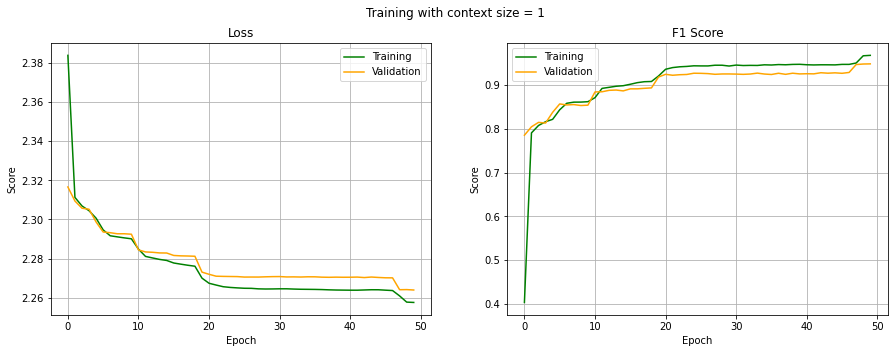

In [22]:
now = datetime.now(pytz.timezone("Asia/Ujung_Pandang"))
path_name = now.strftime("%m-%d-%Y_%H-%M-%S")
root_path = f"../../../logs/classifier/{hyperparams.context_size}_contexts/fold_0{hyperparams.fold}/{path_name}"
os.makedirs(root_path)

def looping_step(train_dataloader, val_dataloader, model, optimizer, criterion, train_metric, val_metric, n_epoch=hyperparams.n_epoch, patience=hyperparams.patience, monitor="loss"):    
    start_time = time()
    
    epoch_training_losses = []
    epoch_training_metric_scores = []
    epoch_val_losses = []
    epoch_val_metric_scores = []
    patience_counter = 0
    
    # Hyperparameters
    with open(f"{root_path}/training_history.txt", "a") as f:
        f.write(f"HYPERPARAMETERS\n")
        f.write(f"{'-' * 80}\n")
        for name, value in vars(hyperparams).items():
            f.write(f"{name}: {value}\n")
        
        f.write("\n\nTRAINING PROGRESS\n")
        f.write(f"{'-' * 80}\n")
    
    # Training Progress
    for epoch in range(1, n_epoch + 1):
        print(f"EPOCH-{epoch}")
        with open(f"{root_path}/training_history.txt", "a") as f:
            f.write(f"EPOCH-{epoch}\n")
            f.write(f"Training Step\n")
            
        # Training Step
        print("Training Step")
        batch_training_losses, batch_training_metric_scores = training_step(train_dataloader, model, optimizer, criterion, train_metric, scheduler=None)
        epoch_training_loss = torch.mean(torch.FloatTensor(batch_training_losses))

        epoch_training_loss = torch.mean(torch.FloatTensor(batch_training_losses))
        epoch_training_losses.append(epoch_training_loss.item())

        epoch_training_metric_score = torch.mean(torch.FloatTensor(batch_training_metric_scores))
        epoch_training_metric_scores.append(epoch_training_metric_score.item())
        
        # Validation Step
        with open(f"{root_path}/training_history.txt", "a") as f:
            f.write(f"\nValidation Step\n")
            
        print("\nValidation Step")
        batch_val_losses, batch_val_metric_scores = validation_step(val_dataloader, model, criterion, val_metric)
        epoch_val_loss = torch.mean(torch.FloatTensor(batch_val_losses))

        epoch_val_loss = torch.mean(torch.FloatTensor(batch_val_losses))
        epoch_val_losses.append(epoch_val_loss.item())

        epoch_val_metric_score = torch.mean(torch.FloatTensor(batch_val_metric_scores))
        epoch_val_metric_scores.append(epoch_val_metric_score.item())
        
        with open(f"{root_path}/training_history.txt", "a") as f:
            if monitor == "loss":
                if epoch == 1:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                elif epoch_training_losses[-1] < epoch_training_losses[-2]:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print("\nYeah 🎉😄! Model improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write("\nYeah 🎉😄! Model improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                else:
                    patience_counter += 1
                    
                    print("\nHuft 😥! Model not improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    print(f"Patience = {patience_counter}/{patience}❗")
                    
                    f.write("\nHuft 😥! Model not improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                    f.write(f"Patience = {patience_counter}/{patience}❗\n")
            else:
                if epoch == 1:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                elif epoch_training_metric_scores[-1] > epoch_training_metric_scores[-2]:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print("\nYeah 🎉😄! Model improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write("\nYeah 🎉😄! Model improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                else:
                    patience_counter += 1
                    
                    print("\nHuft 😥! Model not improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    print(f"Patience = {patience_counter}/{patience}❗\n")
                    
                    f.write("\nHuft 😥! Model not improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                    f.write(f"Patience = {patience_counter}/{patience}❗\n")
                    
            print("=" * 80, end="\n\n")
            
            f.write(f"{'=' * 80}\n\n")
            
            if patience_counter == patience:
                print(f"Early stopping, patience = {patience_counter}/{patience}❗\n")
                
                f.write(f"Early stopping, patience = {patience_counter}/{patience}❗\n")
                break
        
        train_metric.reset()
        val_metric.reset()
        
    finish_time = time()
    
    # Training plot 
    fig, (ax_loss, ax_metric_score) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

    fig.suptitle(f"Training with context size = {hyperparams.context_size}")

    ax_loss.set_title("Loss")
    ax_loss.set_xlabel("Epoch")
    ax_loss.set_ylabel("Score")
    ax_loss.plot(epoch_training_losses, "green", label="Training")
    ax_loss.plot(epoch_val_losses, "orange", label="Validation")
    ax_loss.legend()
    ax_loss.grid()

    ax_metric_score.set_title("F1 Score")
    ax_metric_score.set_xlabel("Epoch")
    ax_metric_score.set_ylabel("Score")
    ax_metric_score.plot(epoch_training_metric_scores, "green", label="Training")
    ax_metric_score.plot(epoch_val_metric_scores, "orange", label="Validation")
    ax_metric_score.legend()
    ax_metric_score.grid()

    plt.savefig(f"{root_path}/training_plot.jpg", dpi=200)                        
    
    print("TRAINING SUMMARY")
    name_best_training_loss = f"Best {str(criterion).split('(')[0]} training".ljust(34)
    name_best_training_metric = f"Best {str(train_metric).split('(')[0]} validation".ljust(34)
    name_best_validation_loss = f"Best {str(criterion).split('(')[0]} training".ljust(34)
    name_best_validation_metric = f"Best {str(val_metric).split('(')[0]} validation".ljust(34)
    name_training_time = f"Training duration".ljust(34)
    name_training_date = f"Training date".ljust(34)
    
    print(f"{name_best_training_loss}: {best_training_loss:.4f}")
    print(f"{name_best_validation_loss}: {best_val_loss:.4f}")
    print(f"{name_best_training_metric}: {best_training_metric:.4f}")
    print(f"{name_best_validation_metric}: {best_val_metric:.4f}")
    print(f"{name_training_time}: {((finish_time - start_time) / 60):.4f} minutes.")
    print(f"{name_training_date}: {now}")
    
    with open(f"{root_path}/training_history.txt", "a") as f:
        f.write("\nTRAINING SUMMARY\n")
        f.write(f"{'-' * 80}\n")
        f.write(f"{name_best_training_loss}: {best_training_loss:.4f}\n")
        f.write(f"{name_best_validation_loss}: {best_val_loss:.4f}\n")
        f.write(f"{name_best_training_metric}: {best_training_metric:.4f}\n")
        f.write(f"{name_best_validation_metric}: {best_val_metric:.4f}\n")
        f.write(f"{name_training_time}: {((finish_time - start_time) / 60):.4f} minutes.\n")
        f.write(f"{name_training_date}: {now}\n")
    
    # Save epoch losses, epoch metric scores, model, state dict, and oov embedding dict
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "loss": epoch_training_losses
    }).to_csv(f"{root_path}/training_losses.csv", index=False)
    
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "f1_score": epoch_training_metric_scores
    }).to_csv(f"{root_path}/training_metric_scores.csv", index=False)
    
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "loss": epoch_val_losses
    }).to_csv(f"{root_path}/val_losses.csv", index=False)
    
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "f1_score": epoch_val_metric_scores
    }).to_csv(f"{root_path}/val_metric_scores.csv", index=False)    
    
    filename_model_params = f"{root_path}/model_params.pth"
    torch.save(best_state_dict, filename_model_params)
    
    return epoch_training_losses, epoch_training_metric_scores, epoch_val_losses, epoch_val_metric_scores

epoch_training_losses, epoch_training_metric_scores, epoch_val_losses, epoch_val_metric_scores = looping_step(train_dataloader, val_dataloader, model, optimizer, criterion, train_metric, val_metric)

## End Training

# Evaluation

In [23]:
def evaluation(dataloader, model, criterion, metric):
    model.eval()
    
    with torch.inference_mode():
        for batch, (feature, actual_label) in enumerate(tqdm(dataloader), 1):
            # Forward Propagation
            feature = rearrange(feature, "n s -> s n")
            actual_label = rearrange(actual_label, "n s -> s n")
            embedding = word_embeddings(feature)

            prob = model(
                embedding.to(hyperparams.device),
                actual_label.to(hyperparams.device)
            )

            prob = prob.reshape(-1, prob.shape[-1])
            actual_label = actual_label.reshape(-1)
            pred = rearrange(prob.argmax(dim=1).reshape(feature.shape[0], len(dataloader.dataset)), "s n -> n s")

            loss = criterion(prob, actual_label.to(hyperparams.device))
            metric_score = metric(prob.argmax(dim=1), actual_label.to(hyperparams.device))
            metric_score = metric.compute()

    return loss, metric_score, pred

train_dataloader = DataLoader(train_dataset, batch_size=len(train_dataset))
val_dataloader = DataLoader(val_dataset, batch_size=len(val_dataset))
test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset))

criterion = nn.CrossEntropyLoss().to(hyperparams.device)
metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="samplewise", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
train_loss, train_f1_score, train_pred_label = evaluation(train_dataloader, model, criterion, metric)

criterion = nn.CrossEntropyLoss().to(hyperparams.device)
metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="samplewise", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
val_loss, val_f1_score, val_pred_label = evaluation(val_dataloader, model, criterion, metric)

criterion = nn.CrossEntropyLoss().to(hyperparams.device)
metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="samplewise", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
test_loss, test_f1_score, test_pred_label = evaluation(test_dataloader, model, criterion, metric)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [24]:
train_f1_score, val_f1_score, test_f1_score

(tensor(0.9678, device='cuda:0'),
 tensor(0.9475, device='cuda:0'),
 tensor(0.9466, device='cuda:0'))

In [25]:
train_f1_score, val_f1_score, test_f1_score

(tensor(0.9678, device='cuda:0'),
 tensor(0.9475, device='cuda:0'),
 tensor(0.9466, device='cuda:0'))

## Heatmap

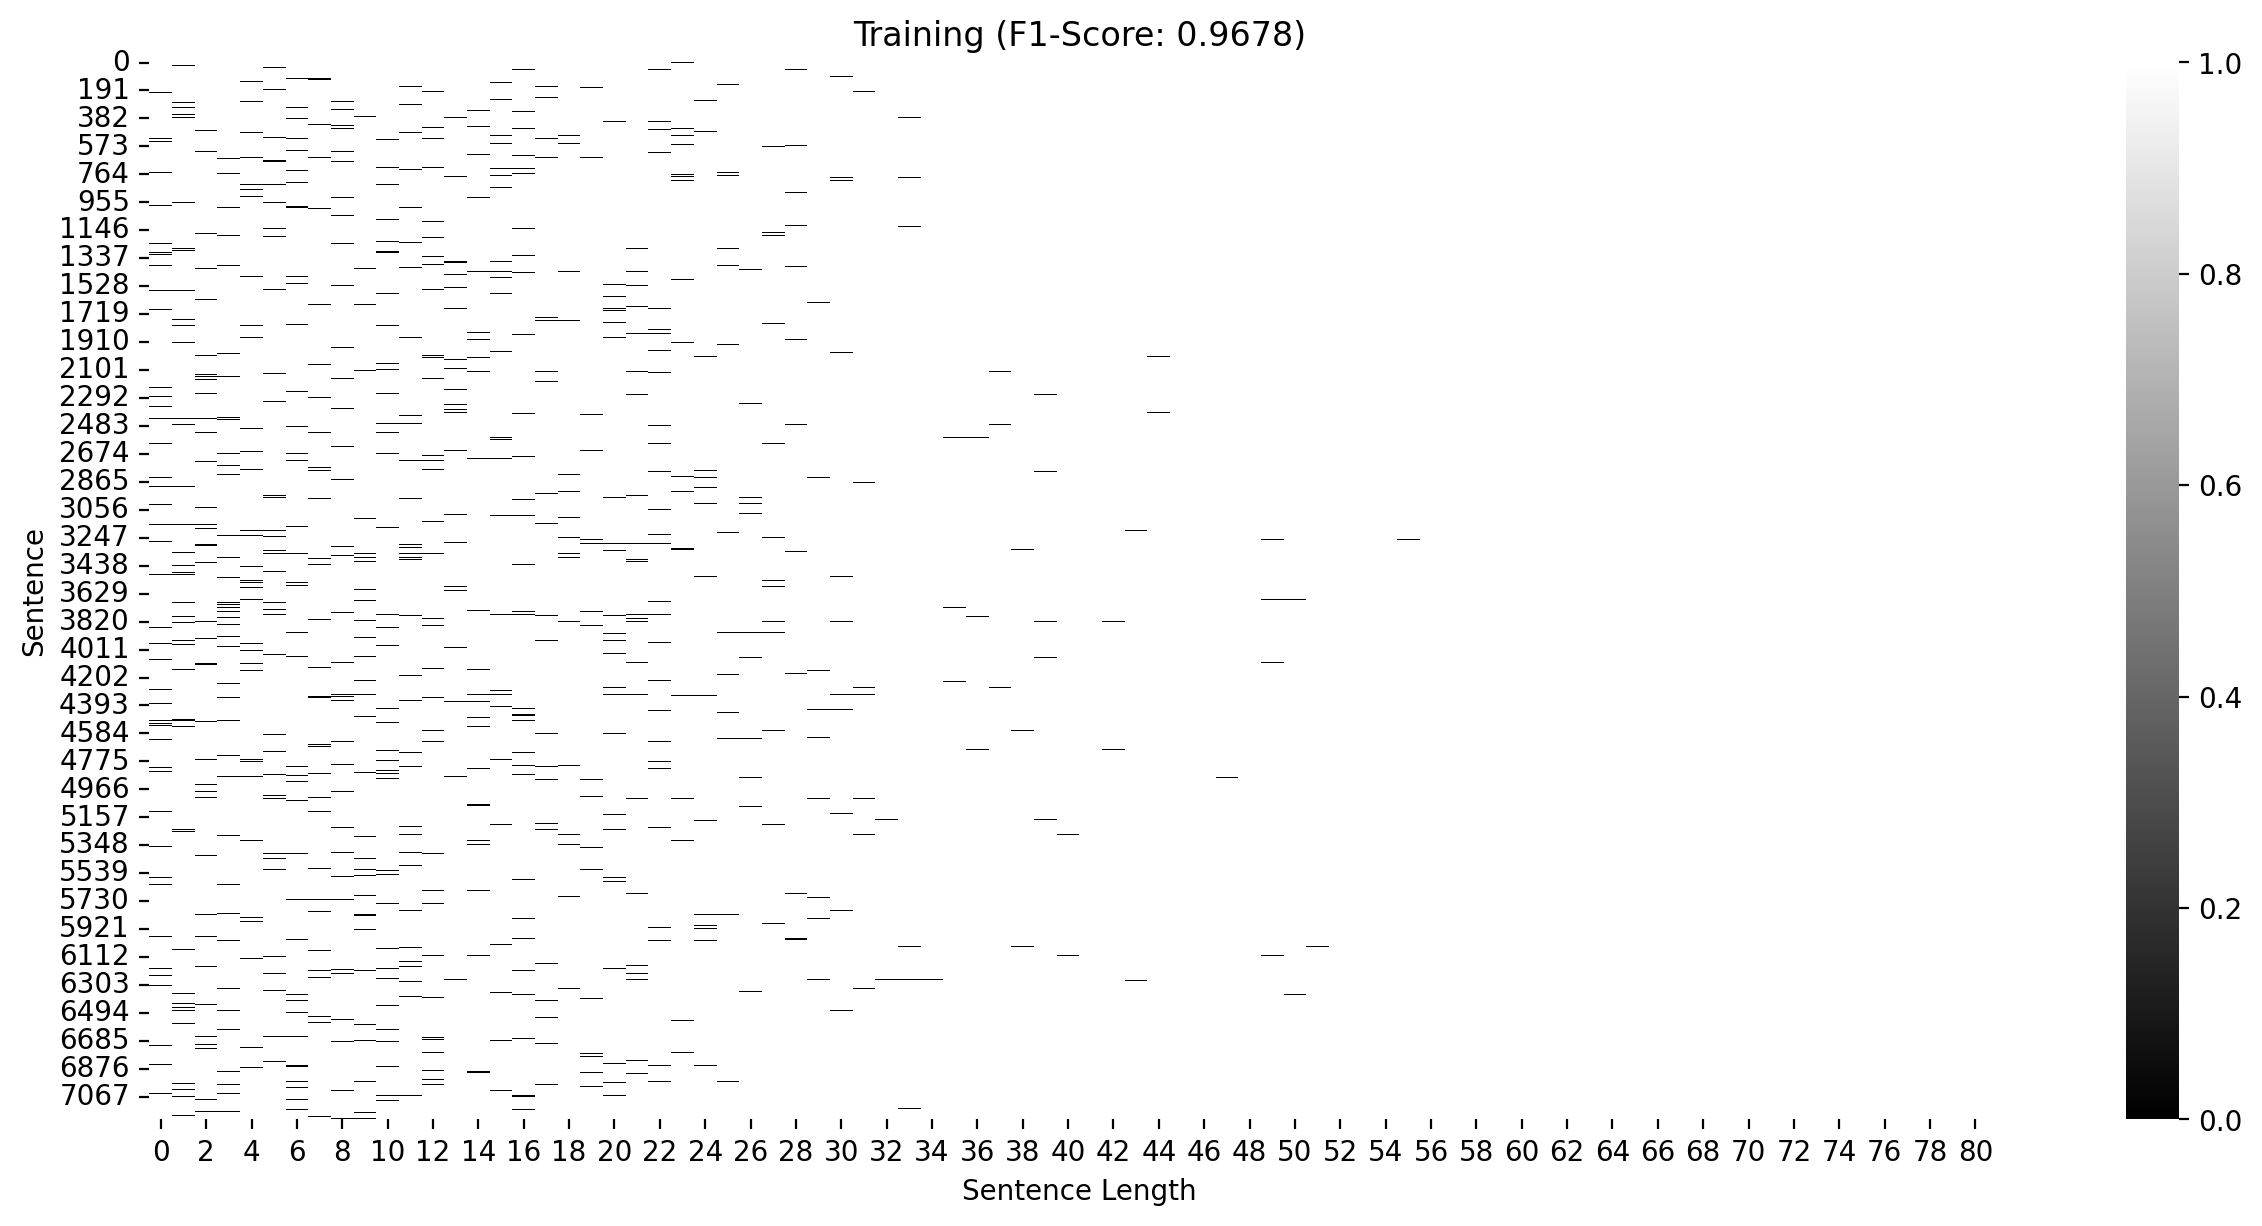

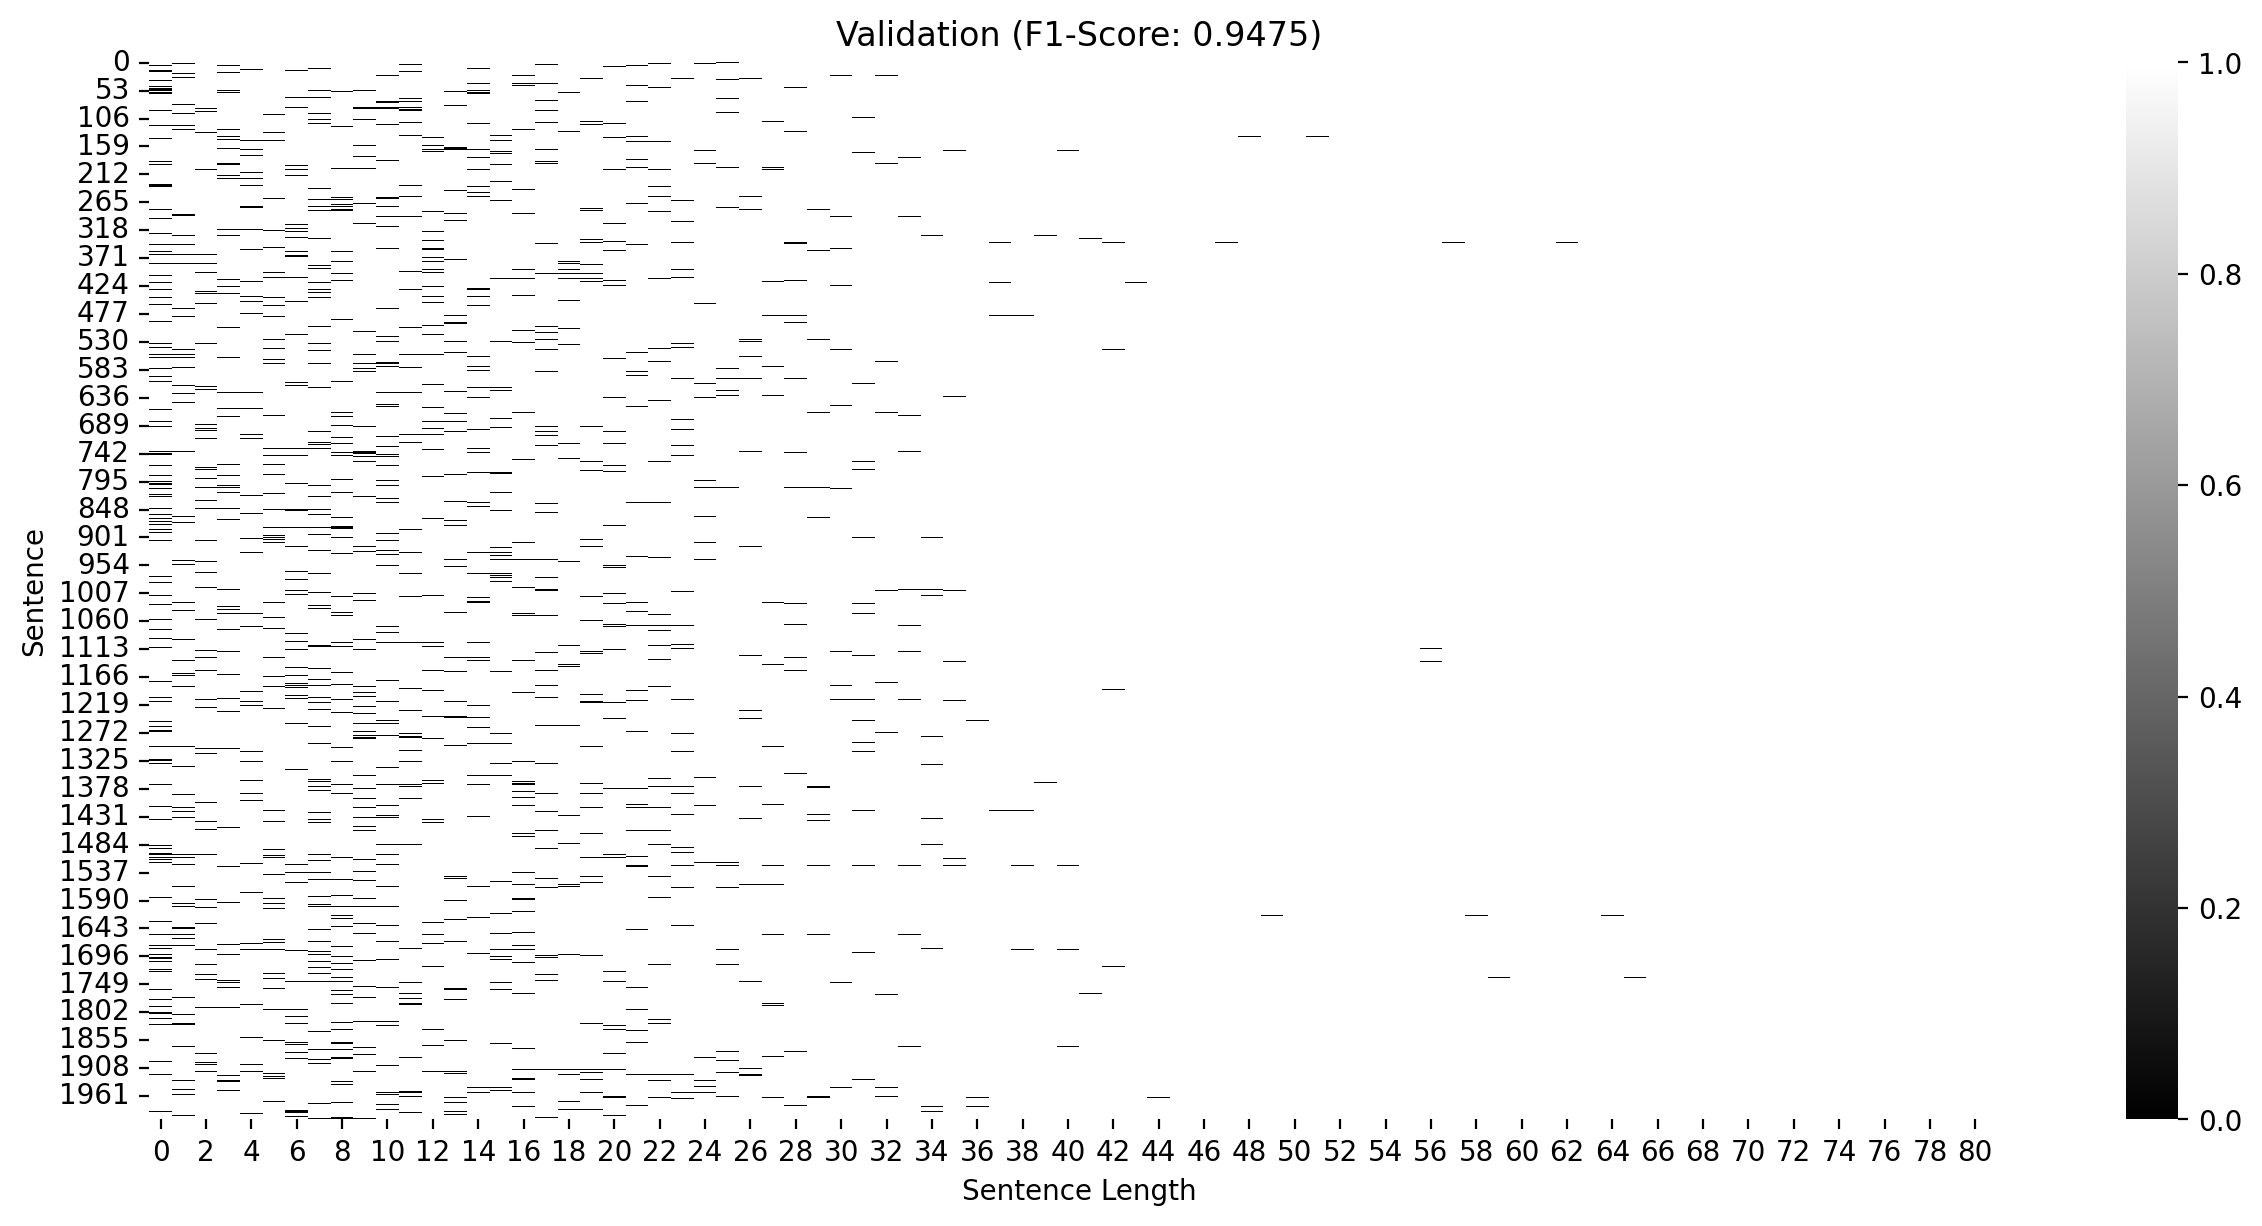

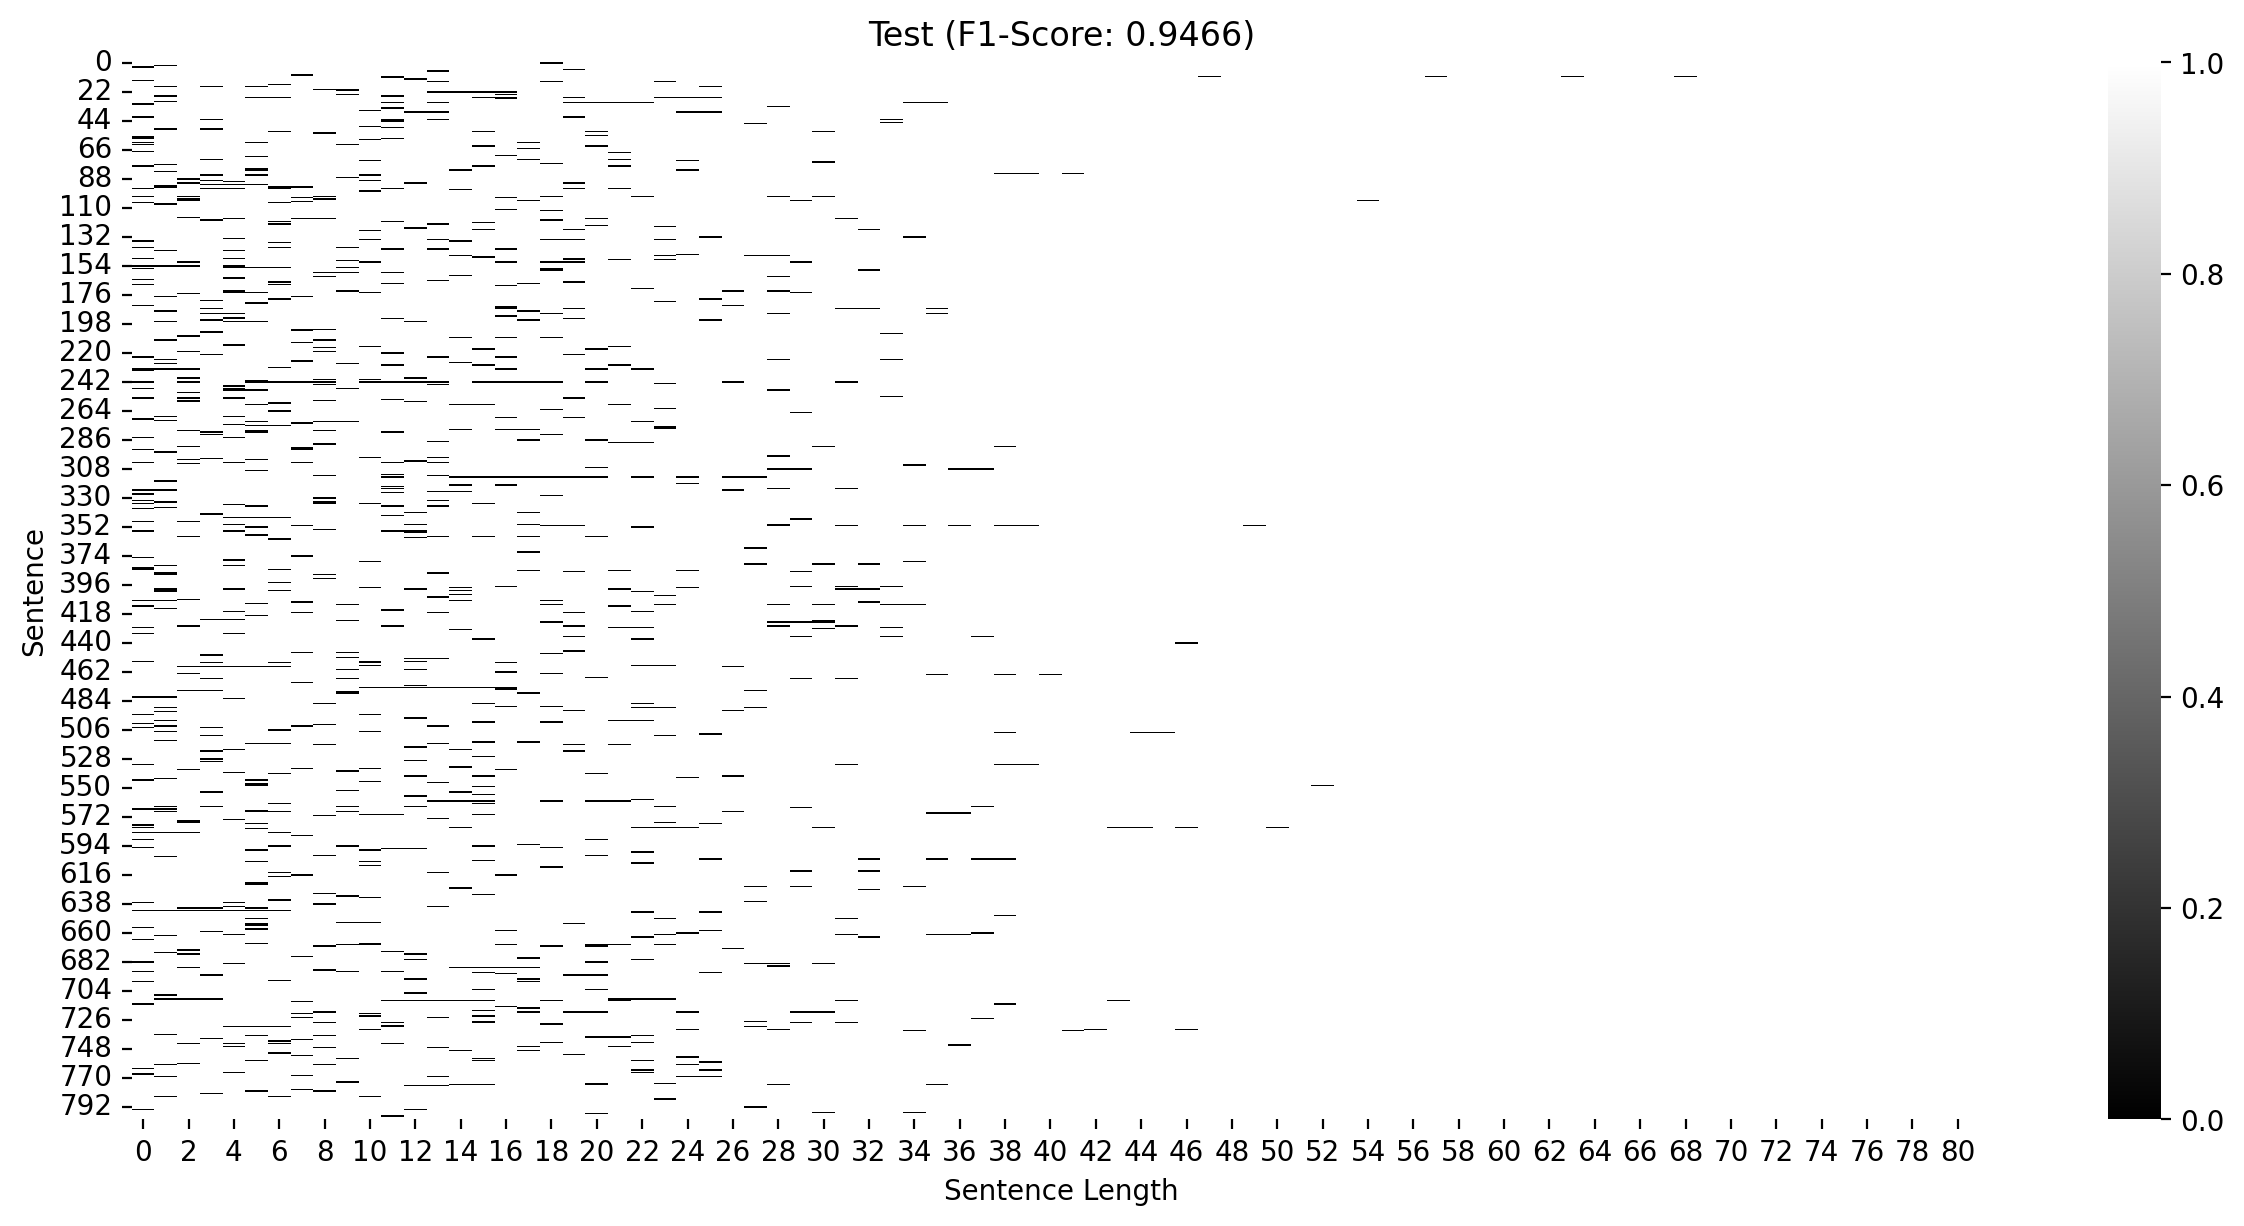

In [26]:
import seaborn as sns

def viz_evaluation(pred_label, actual_label, title):
    plt.figure(figsize=(15, 7), dpi=200)
    sns.heatmap(pred_label.detach().cpu() == actual_label, cbar=True, cmap="binary_r")
    plt.xlabel("Sentence Length")
    plt.ylabel("Sentence")
    plt.title(title)
    plt.savefig(f"{root_path}/heatmap_{title.lower()}.jpg", dpi=200)
    plt.show()

train_actual_label = train_dataloader.dataset.tensors[1]
val_actual_label = val_dataloader.dataset.tensors[1]
test_actual_label = test_dataloader.dataset.tensors[1]

viz_evaluation(train_pred_label, train_actual_label, f"Training (F1-Score: {(train_f1_score):.4f})")
viz_evaluation(val_pred_label, val_actual_label, f"Validation (F1-Score: {(val_f1_score):.4f})")
viz_evaluation(test_pred_label, test_actual_label, f"Test (F1-Score: {(test_f1_score):.4f})")

## Confusion Matrix

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: 144 NaN values found in confusion matrix have been replaced with zeros.
  warnings.warn(*args, **kwargs)
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: 168 NaN values found in confusion matrix have been replaced with zeros.
  warnings.warn(*args, **kwargs)


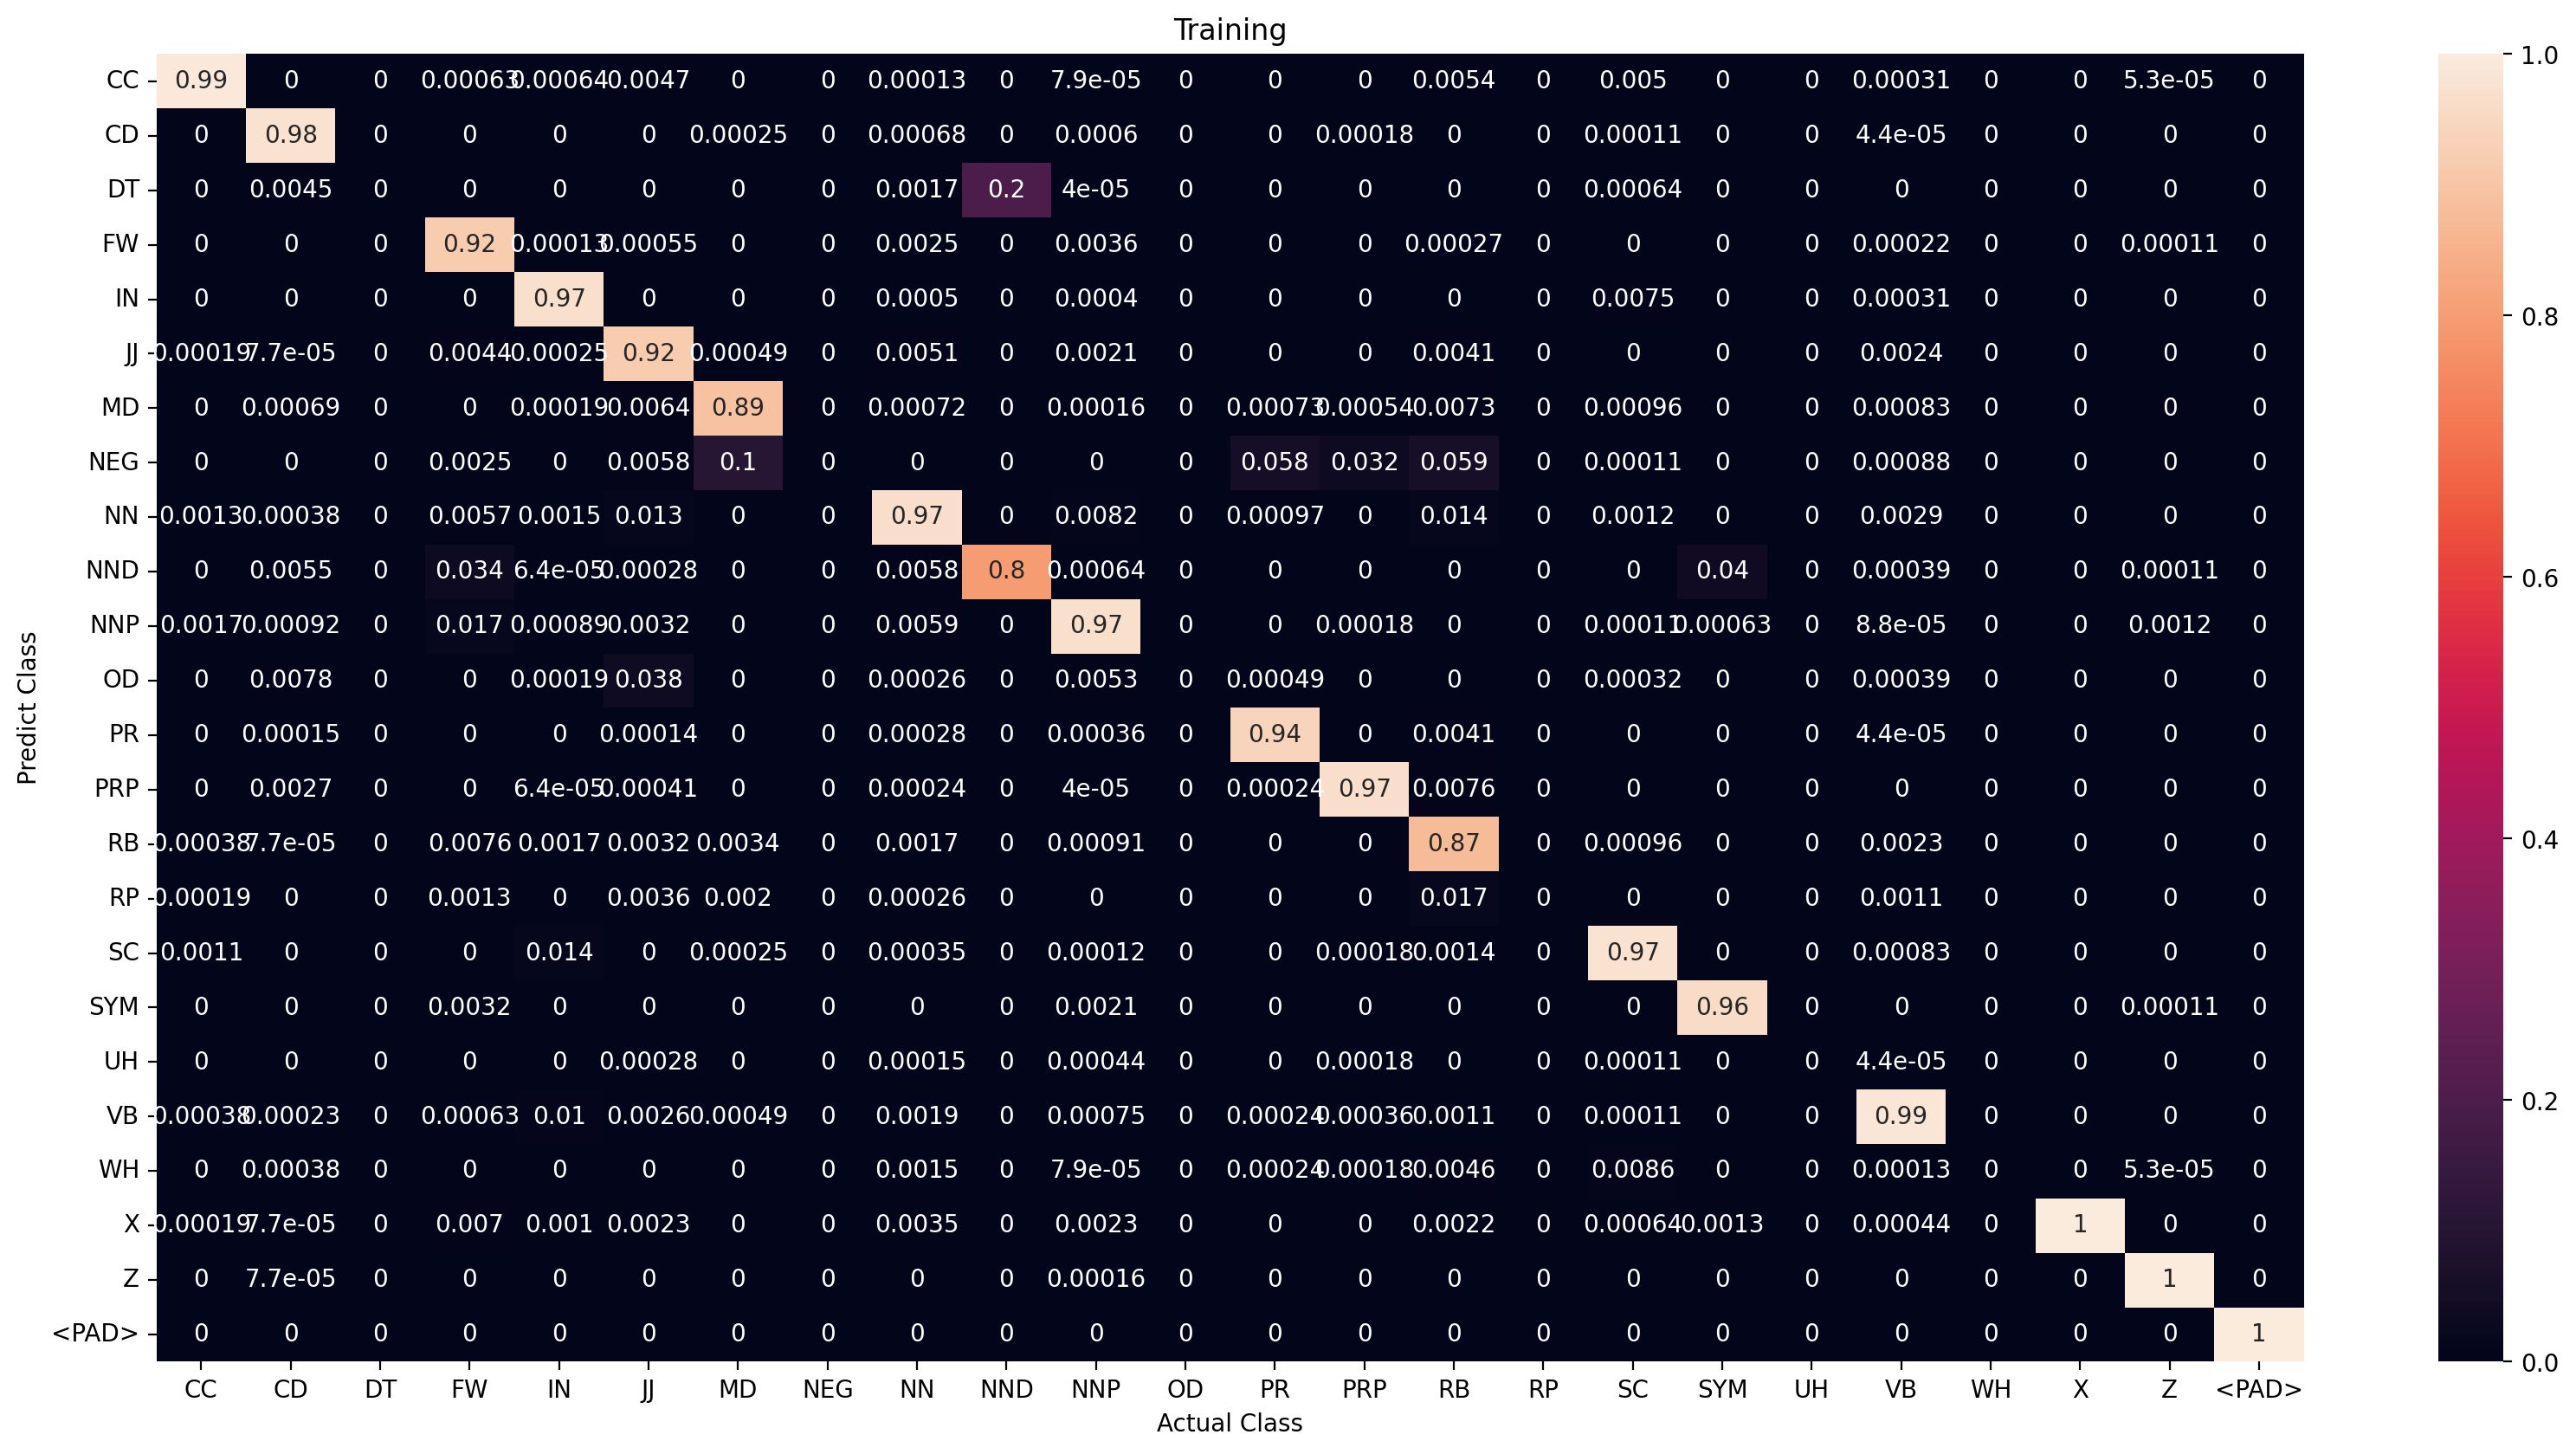

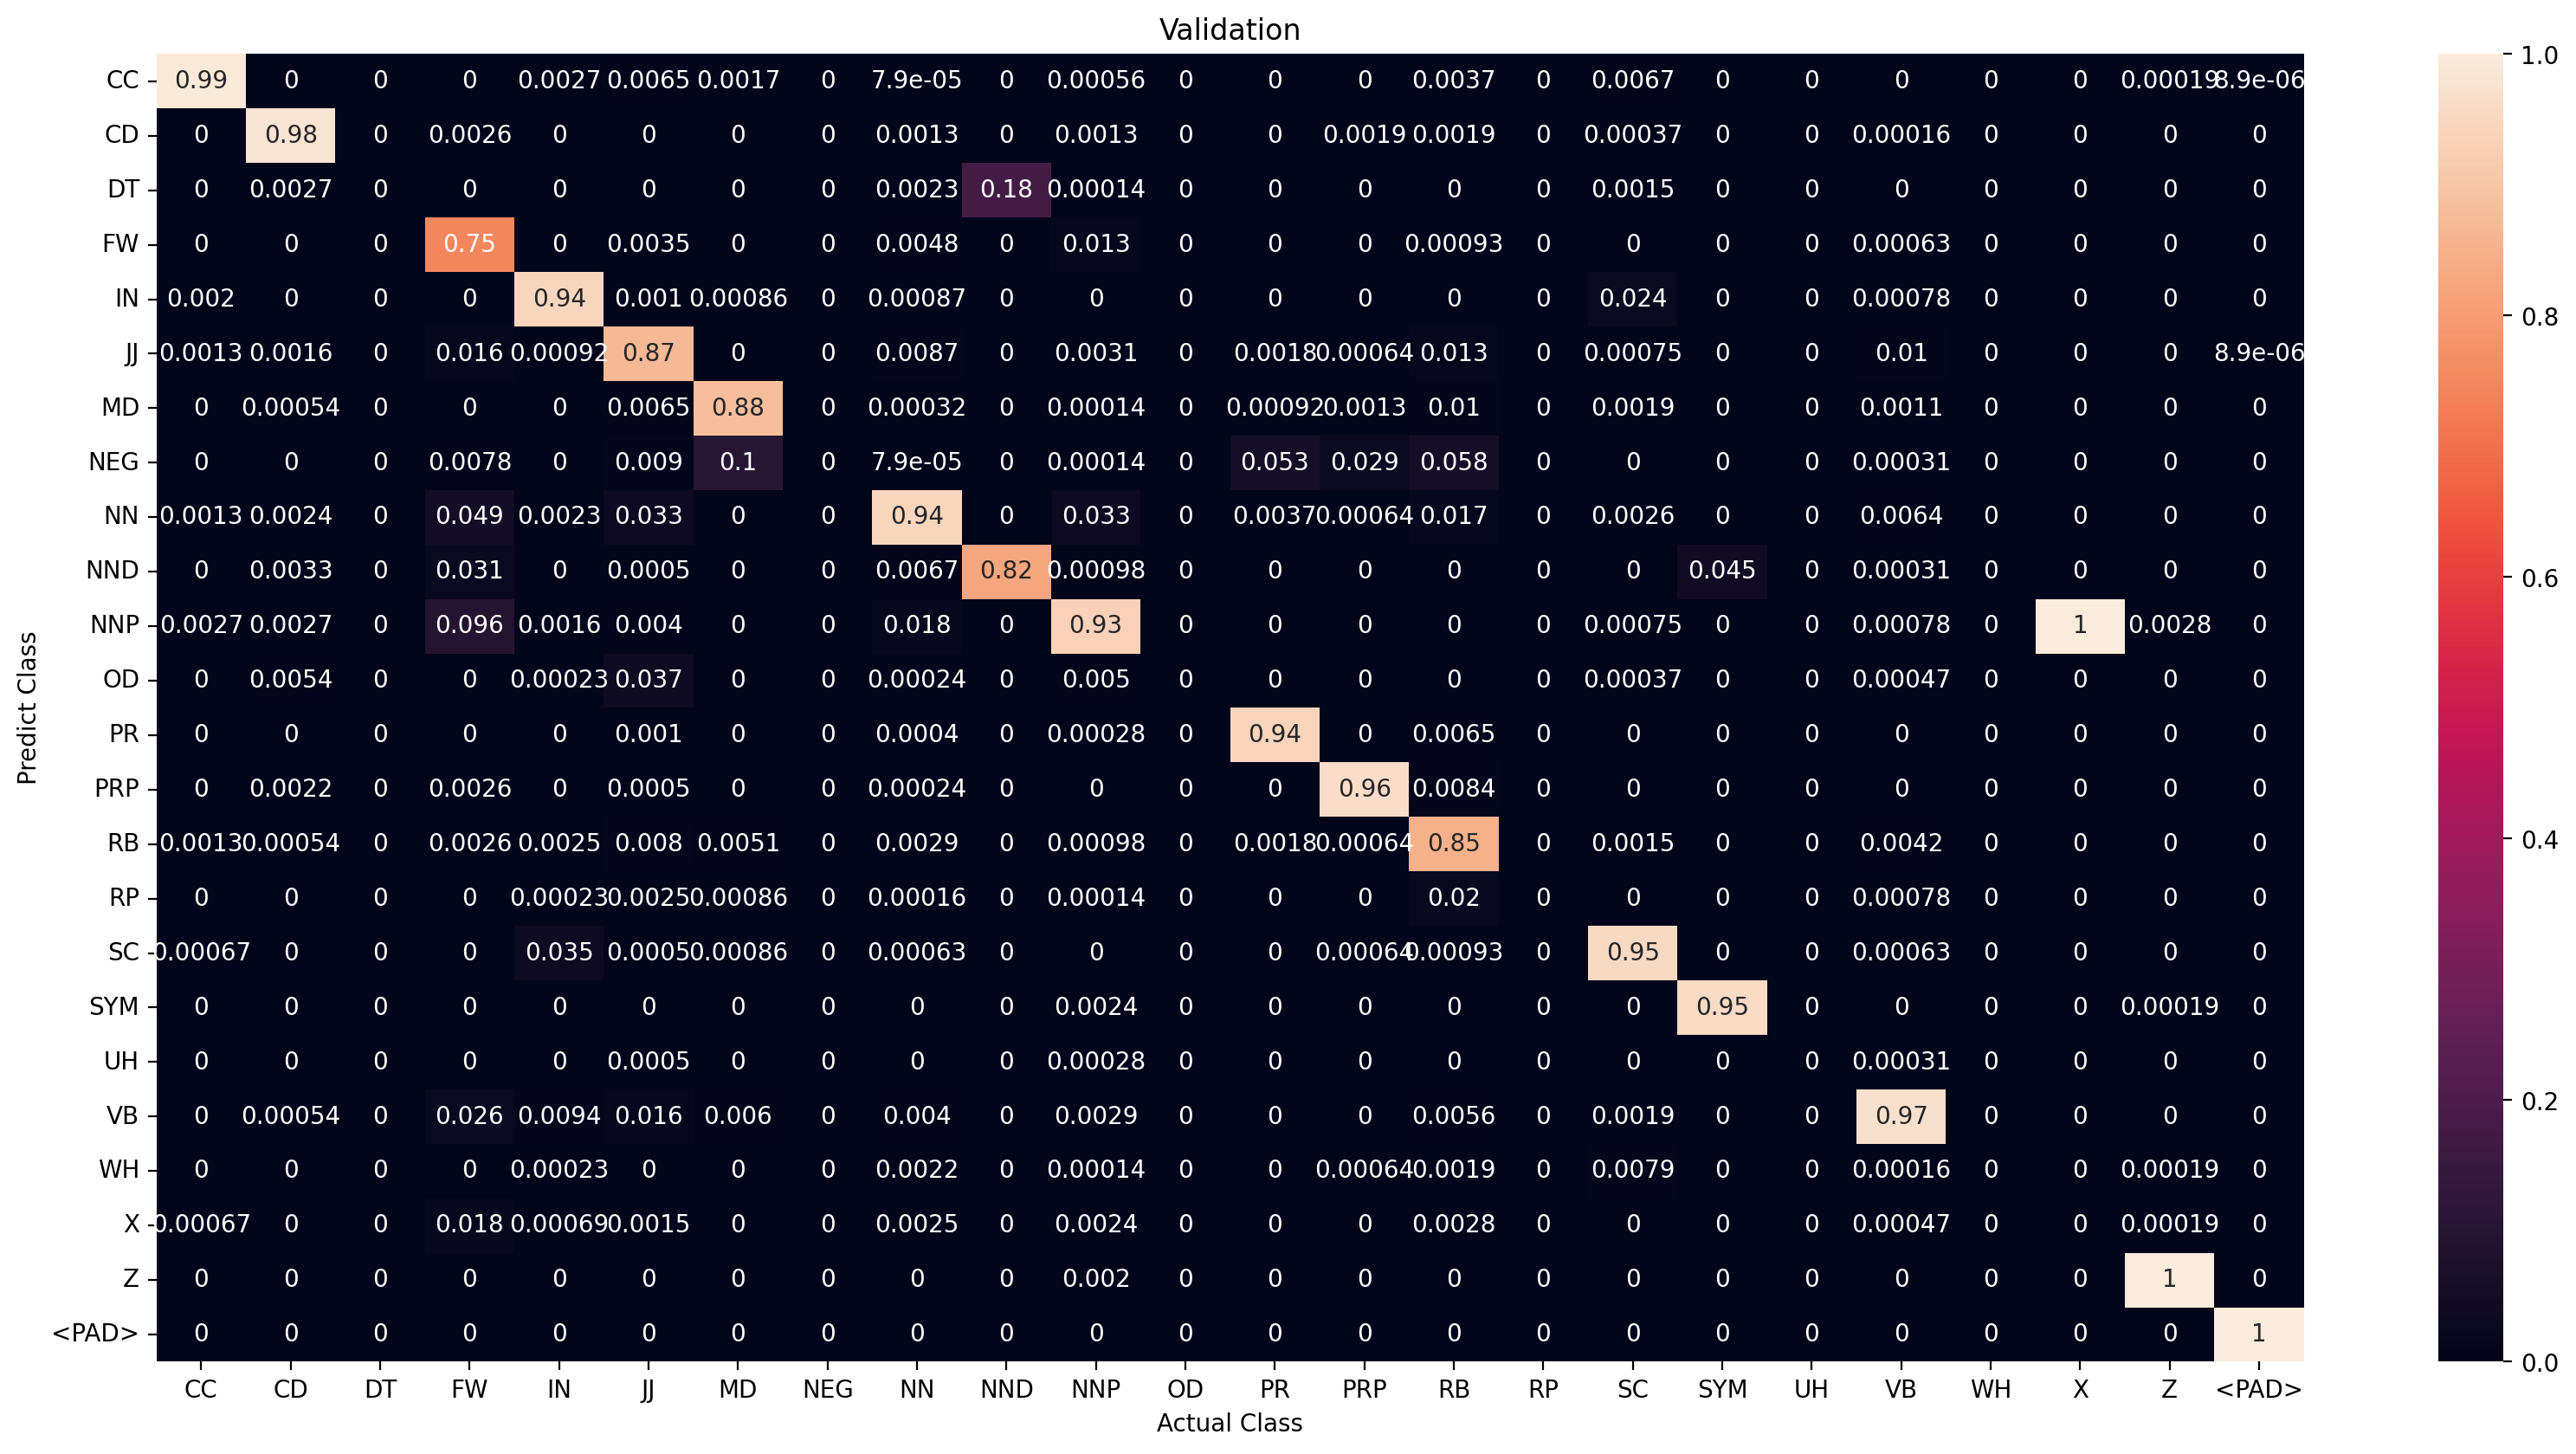

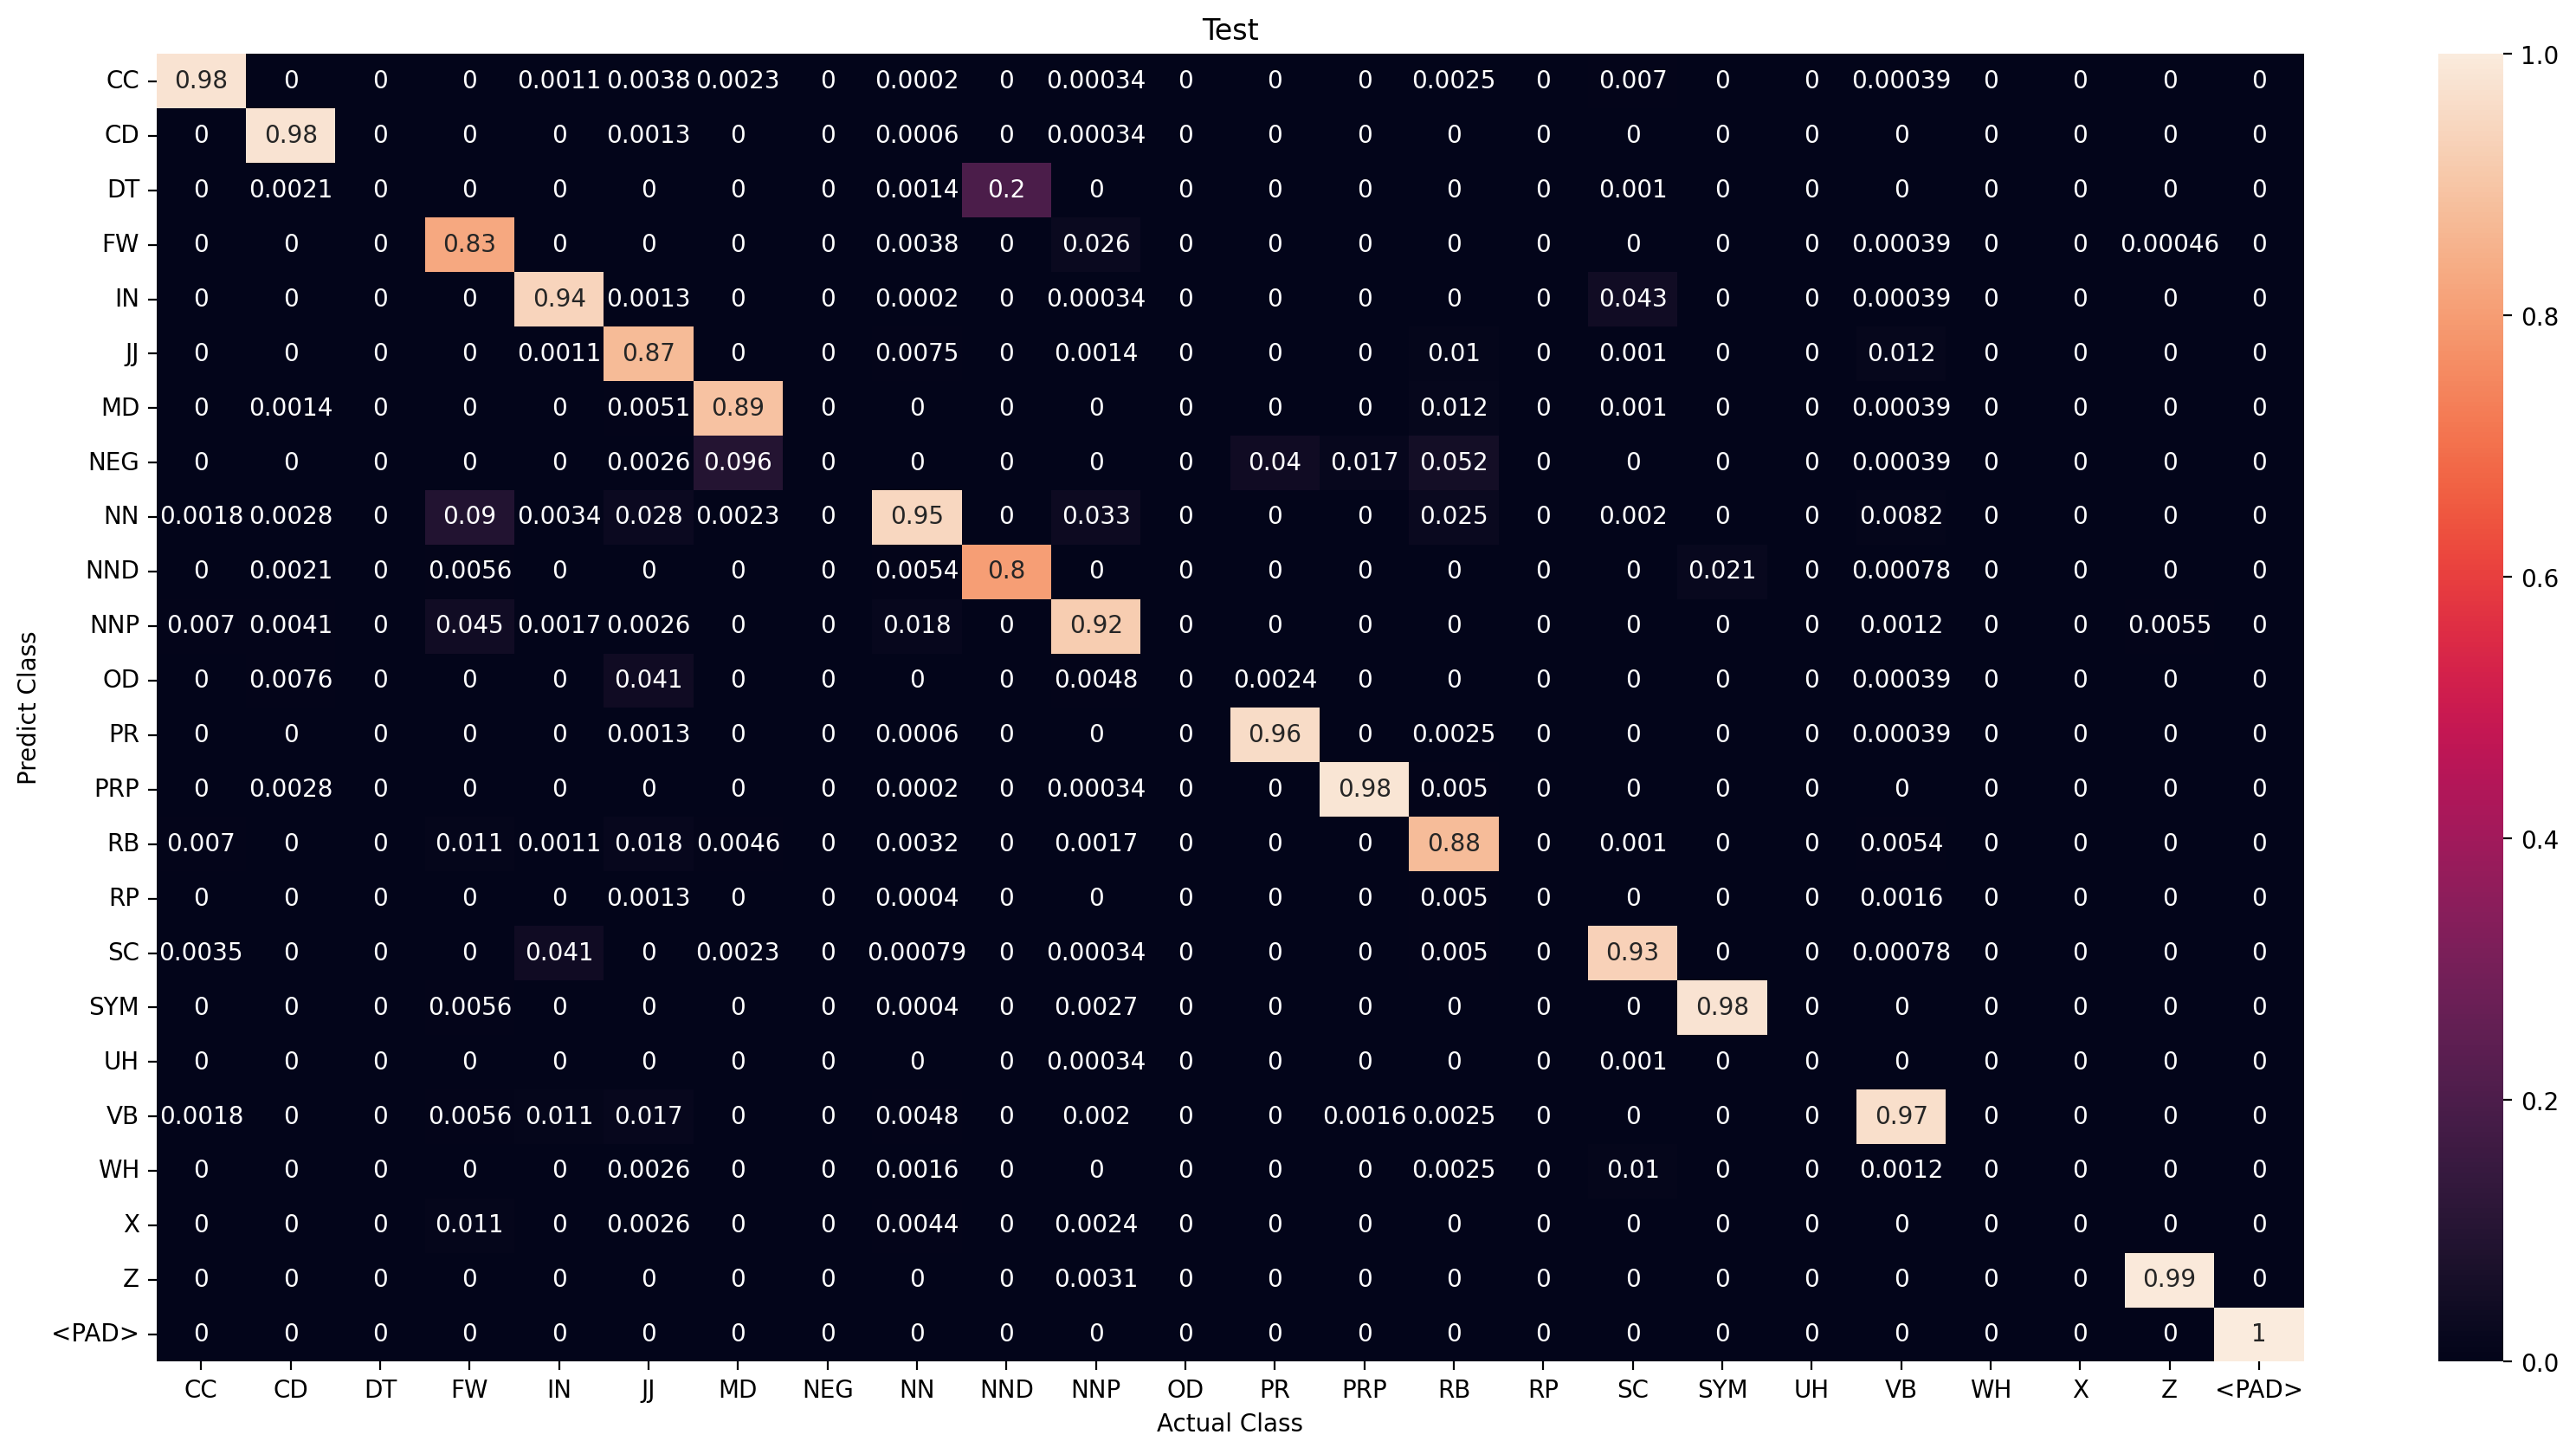

In [27]:
def confusion_matrix(pred_class, actual_class, title, normalize=None):
    conf_mat = MulticlassConfusionMatrix(num_classes=24, normalize=normalize)
    plt.figure(figsize=(20, 10), dpi=200)
    sns.heatmap(conf_mat(pred_class.detach().cpu(), actual_class), annot=True, fmt=".2g", xticklabels=list(label_to_idx.keys()), yticklabels=list(label_to_idx.keys()));
    plt.yticks(rotation=0)
    plt.title(title)
    plt.xlabel("Actual Class")
    plt.ylabel("Predict Class")
    plt.savefig(f"{root_path}/conf_matrix_{title.lower()}.jpg", dpi=200)

confusion_matrix(train_pred_label, train_actual_label, "Training", "pred")
confusion_matrix(val_pred_label,val_actual_label, "Validation", "pred")
confusion_matrix(test_pred_label, test_actual_label, "Test", "pred")

## Prediction Table

In [28]:
def number_wrong_pred_each_class(pred_class, actual_class):
    classes, count_class = actual_class.flatten().unique(return_counts=True)
    conf_mat = MulticlassConfusionMatrix(num_classes=24, normalize="none")
    correct_pred_count_class = conf_mat(pred_class.detach().cpu(), actual_class).diag()
    
    correct_pred = {idx_to_label[label.item()]: count.item() for label, count in zip(classes, (correct_pred_count_class))}
    wrong_pred = {idx_to_label[label.item()]: count.item() for label, count in zip(classes, (count_class - correct_pred_count_class))}
    
    return correct_pred, wrong_pred

correct_pred, wrong_pred = number_wrong_pred_each_class(train_pred_label, train_actual_label)
print(f"| {'Number class'.ljust(14)} | {'Correct prediction'.ljust(12)} | {'Wrong prediction'.ljust(12)} |")
for (label_correct_pred, count_correct_pred), (label_wrong_pred, count_wrong_pred) in zip(correct_pred.items(), wrong_pred.items()):
    print(f"| {str(label_correct_pred).ljust(6)}: {str(count_correct_pred + count_wrong_pred).ljust(7)}| {label_correct_pred.ljust(6)}: {str(count_correct_pred).ljust(10)} | {label_wrong_pred.ljust(6)}: {str(count_wrong_pred).ljust(8)} |")

| Number class   | Correct prediction | Wrong prediction |
| CC    : 5322   | CC    : 5194       | CC    : 128      |
| CD    : 12758  | CD    : 12708      | CD    : 50       |
| DT    : 277    | DT    : 0          | DT    : 277      |
| FW    : 1666   | FW    : 1445       | FW    : 221      |
| IN    : 15371  | IN    : 15261      | IN    : 110      |
| JJ    : 6997   | JJ    : 6626       | JJ    : 371      |
| MD    : 3774   | MD    : 3618       | MD    : 156      |
| NEG   : 1113   | NEG   : 0          | NEG   : 1113     |
| NN    : 44672  | NN    : 44194      | NN    : 478      |
| NND   : 1021   | NND   : 539        | NND   : 482      |
| NNP   : 24845  | NNP   : 24465      | NNP   : 380      |
| OD    : 541    | OD    : 0          | OD    : 541      |
| PR    : 3896   | PR    : 3855       | PR    : 41       |
| PRP   : 5408   | PRP   : 5328       | PRP   : 80       |
| RB    : 3463   | RB    : 3221       | RB    : 242      |
| RP    : 137    | RP    : 0          | RP    : 137     

In [29]:
train_actual_label[308], train_pred_label[308]

(tensor([ 8, 19, 22, 10, 22, 19, 10,  6, 19,  4,  1,  8, 16, 19,  8, 19,  0,  8,
          5, 16, 19, 19,  8,  8, 22, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23]),
 tensor([ 8, 19, 22, 10, 22, 19, 10,  6, 19,  4,  1,  8, 16, 19,  8, 19,  0,  8,
          5, 16, 19, 19,  8,  8, 22, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23], device='cuda:0'))

In [30]:
train_actual_label[308].detach().cpu() == train_pred_label[308].detach().cpu()

tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True])

## OOV prediction is correct 

In [31]:
def oov_flag_token(sentences, max_seq_len=hyperparams.max_seq_len):
    sent_copy = deepcopy(sentences)
    sent = []
    oov_flag = []
    
    for sentence in tqdm(sent_copy):
        for token in sentence:
            sent.append(token[2])
        
        for _ in range(max_seq_len- len(sentence)):
            sent.append(False)
        
        oov_flag.append(sent)
        sent = []
        
    return np.array(oov_flag)

train_oov_flag = oov_flag_token(train_sentences, max_seq_len=hyperparams.max_seq_len)
val_oov_flag = oov_flag_token(val_sentences, max_seq_len=hyperparams.max_seq_len)
test_oov_flag = oov_flag_token(test_sentences, max_seq_len=hyperparams.max_seq_len)

def pencentage_oov_pred_correct(pred_oov_flag, oov_flag_tensor):
    oov_correct_counter = 0
    oov_wrong_counter = 0

    for pred, oov_label in tqdm(zip(pred_oov_flag, oov_flag_tensor)):
        if pred == True and oov_label == True:
            oov_correct_counter += 1
        elif pred == False and oov_label == True:
            oov_wrong_counter += 1
        else:
            continue
            
    return oov_correct_counter, oov_wrong_counter

train_pred_oov_flag = (train_actual_label == train_pred_label.detach().cpu()).flatten()
val_pred_oov_flag = (val_actual_label == val_pred_label.detach().cpu()).flatten()
test_pred_oov_flag = (test_actual_label == test_pred_label.detach().cpu()).flatten()
train_oov_flag_tensor = torch.tensor(train_oov_flag).flatten()
val_oov_flag_tensor = torch.tensor(val_oov_flag).flatten()
test_oov_flag_tensor = torch.tensor(test_oov_flag).flatten()

train_oov_correct_counter, train_oov_wrong_counter = pencentage_oov_pred_correct(train_pred_oov_flag, train_oov_flag_tensor)
val_oov_correct_counter, val_oov_wrong_counter = pencentage_oov_pred_correct(val_pred_oov_flag, val_oov_flag_tensor)
test_oov_correct_counter, test_oov_wrong_counter = pencentage_oov_pred_correct(test_pred_oov_flag, test_oov_flag_tensor)

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [32]:
def print_percentage_pred_oov(title, oov_correct_counter, oov_wrong_counter):
    print(f"{title}")
    print(f"Number OOV token            : {oov_correct_counter + oov_wrong_counter}")
    print(f"Correct prediction          : {oov_correct_counter}")
    print(f"Wrong prediction            : {oov_wrong_counter}")
    print(f"Percentage correct oov pred : {oov_correct_counter / (oov_correct_counter + oov_wrong_counter) * 100}\n")
    
    with open(f"{root_path}/oov_summary.txt", "a") as f:
        f.write(f"{title}\n")
        f.write(f"Number OOV token            : {oov_correct_counter + oov_wrong_counter}\n")
        f.write(f"Correct prediction          : {oov_correct_counter}\n")
        f.write(f"Wrong prediction            : {oov_wrong_counter}\n")
        f.write(f"Percentage correct oov pred : {oov_correct_counter / (oov_correct_counter + oov_wrong_counter) * 100}\n\n")

In [33]:
print_percentage_pred_oov("Training", train_oov_correct_counter, train_oov_wrong_counter)
print_percentage_pred_oov("Validation", val_oov_correct_counter, val_oov_wrong_counter)
print_percentage_pred_oov("Test", test_oov_correct_counter, test_oov_wrong_counter)

Training
Number OOV token            : 11821
Correct prediction          : 11166
Wrong prediction            : 655
Percentage correct oov pred : 94.45901361982911

Validation
Number OOV token            : 3350
Correct prediction          : 2987
Wrong prediction            : 363
Percentage correct oov pred : 89.16417910447761

Test
Number OOV token            : 1391
Correct prediction          : 1259
Wrong prediction            : 132
Percentage correct oov pred : 90.51042415528397



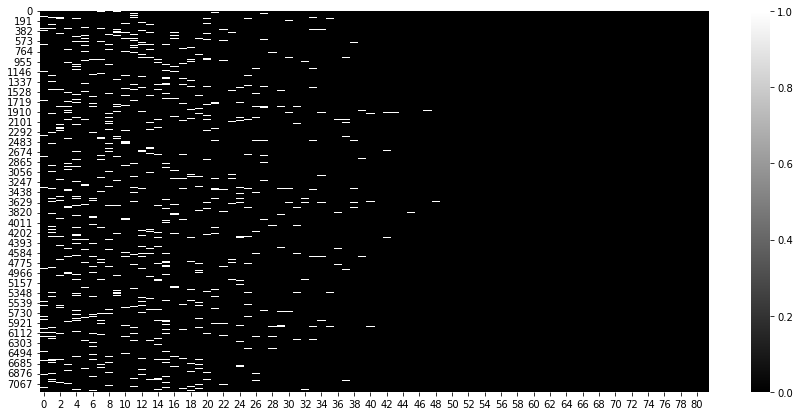

In [34]:
plt.figure(figsize=(15, 7))
sns.heatmap(train_oov_flag, cmap=plt.cm.binary_r);

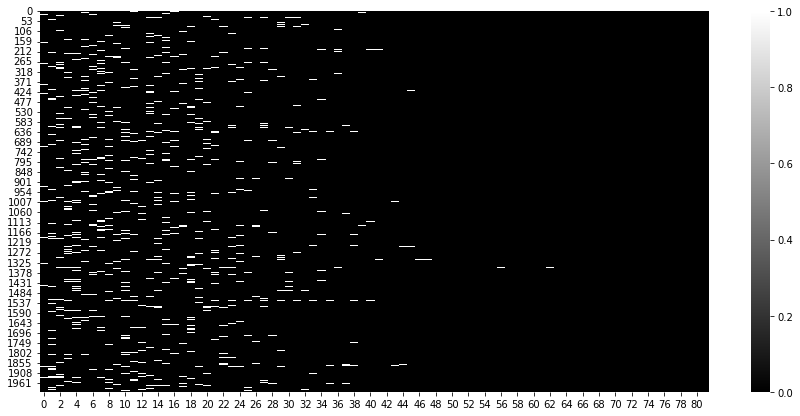

In [35]:
plt.figure(figsize=(15, 7))
sns.heatmap(val_oov_flag, cmap=plt.cm.binary_r);

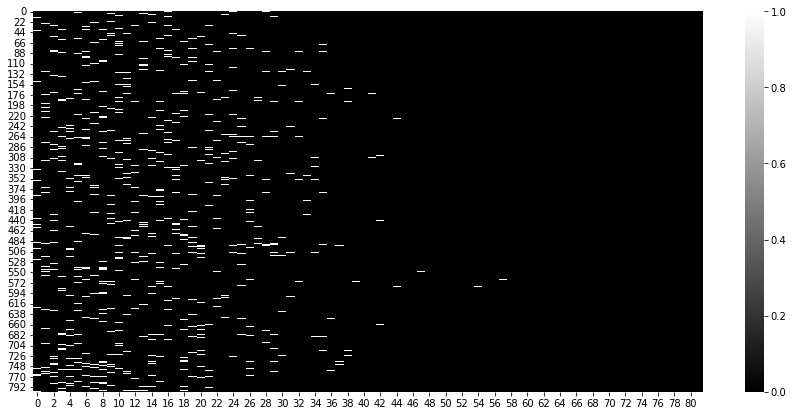

In [36]:
plt.figure(figsize=(15, 7))
sns.heatmap(test_oov_flag, cmap=plt.cm.binary_r);